# Full Code

In [9]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Function to calculate and display feature importance
def get_feature_importance(X, y, model=None, top_n=6, plot=False):
    if model is None:
        model = RandomForestRegressor(n_estimators=50, random_state=42)
    
    model.fit(X, y)
    
    feature_importances = model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    top_features = importance_df.head(top_n)
    
    print(f"Top {top_n} features importance:")
    print(top_features)
    
    if plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
        plt.title("Top Feature Importances")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.show()
    
    return top_features['Feature'].tolist()

# Main training function
def train_model(dataset_id, train_dir="path/to/file", test_dir="path/to/file"):
    
    def load_dataset(dataset_id, train_dir, test_dir):
        train_file = os.path.join(train_dir, f'train_{dataset_id}.csv')
        test_file = os.path.join(test_dir, f'test_{dataset_id}.csv')
        
        train_df = pd.read_csv(train_file, usecols=['timestamp', 'value'], parse_dates=['timestamp'])
        test_df = pd.read_csv(test_file, usecols=['timestamp', 'value'], parse_dates=['timestamp'])
        
        return train_df, test_df
    
    train_df, test_df = load_dataset(dataset_id, train_dir, test_dir)
    
    train_df['dataset_id'] = dataset_id

    training_data = train_df.rename(columns={'timestamp': 'time'}).copy()

    training_data['time'] = pd.to_datetime(training_data['time'])

    training_data = training_data.sort_values('time').reset_index(drop=True)

    def create_features(df):
        # Basic time-based features
        df['hour'] = df['time'].dt.hour
        df['minute'] = df['time'].dt.minute
        df['dayofweek'] = df['time'].dt.dayofweek
        df['month'] = df['time'].dt.month
        df['quarter'] = df['time'].dt.quarter
        df['trend'] = np.arange(len(df))
        
        # Lag features
        df['lag1'] = df['value'].shift(1)
        df['lag2'] = df['value'].shift(2)
        df['lag3'] = df['value'].shift(3)
        df['lag4'] = df['value'].shift(4)
        df['lag5'] = df['value'].shift(5)
    
        # Rolling statistics
        df['rolling_mean_3'] = df['value'].shift(1).rolling(window=3).mean()
        df['rolling_std_3'] = df['value'].shift(1).rolling(window=3).std()
        df['rolling_max_7'] = df['value'].shift(1).rolling(window=7).max()
        df['rolling_min_7'] = df['value'].shift(1).rolling(window=7).min()
        df['rolling_median_7'] = df['value'].shift(1).rolling(window=7).median()

        # Seasonality components as single S values
        df['S_day'] = np.sqrt(
            np.sin(2 * np.pi * df['hour'] / 24) ** 2 +
            np.cos(2 * np.pi * df['hour'] / 24) ** 2
        )
        df['S_week'] = np.sqrt(
            np.sin(2 * np.pi * df['dayofweek'] / 7) ** 2 +
            np.cos(2 * np.pi * df['dayofweek'] / 7) ** 2
        )

        df = df.drop(columns=['time'])        
        return df
    
    training_data = create_features(training_data)

    # Interpolate missing values and drop any NA rows
    training_data = training_data.interpolate(method='linear').dropna()
    
    # feature columns
    feature_cols = [
        'hour', 'minute', 'dayofweek', 'month', 'quarter', 'trend',
        'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
        'rolling_mean_3', 'rolling_std_3', 'rolling_max_7', 'rolling_min_7', 'rolling_median_7',
        'S_day', 'S_week'
    ]
    

    X = training_data[feature_cols]
    y = training_data['value']

    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    
    # Calculate feature importance
    top_features = get_feature_importance(X, y, top_n=3, plot=True)
    
    # Use only the top features for training
    X_top = X_train[top_features]    
    # Train the Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_features='sqrt',
        random_state=42
    )
    rf_model.fit(X_top, y_train)
    rf_pred = rf_model.predict(X_val)
    rf_mse = mean_squared_error(y_val, rf_pred)
    rf_rmse = np.sqrt(rf_mse)
    print(f"Random Forest - Validation MSE for dataset {dataset_id}: {rf_mse:.4f} and RMSE: {rf_rmse:.4f}")

    # Train the XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.12,
        random_state=42,
        eval_metric='rmse'
    )
    xgb_model.fit(X_top, y, eval_set=[(X_top, y_train)], verbose=False)
    xgb_pred = xgb_model.predict(X_val)
    xgb_mse = mean_squared_error(y_val, xgb_pred)
    xgb_rmse = np.sqrt(xgb_mse)
    print(f"XGBoost - Validation MSE for dataset {dataset_id}: {xgb_mse:.4f} and RMSE: {xgb_rmse:.4f}")

    # Ensemble Prediction
    ensemble_pred = (rf_pred + xgb_pred) / 2
    ensemble_mse = mean_squared_error(y_val, ensemble_pred)
    ensemble_rmse = np.sqrt(ensemble_mse)
    print(f"Ensemble - Validation MSE for dataset {dataset_id}: {ensemble_mse:.4f} and RMSE: {ensemble_rmse:.4f}")

    def predict_next_value(request_body):
        dataset_id_input = request_body['dataset_id']
        values = request_body['values']
        
        if dataset_id_input != dataset_id:
            return {'error': f'This model only supports dataset_id {dataset_id}.'}
        
        df = pd.DataFrame(values)
        df['time'] = pd.to_datetime(df['timestamp'])
        df = df.rename(columns={'value': 'value'}).sort_values('time')
        
        df = create_features(df)
        df = df.interpolate(method='linear').dropna()

        # df = df.drop(columns=['time', 'timestamp'])
        
        if df.empty:
            return {'error': 'Not enough data to make a prediction.'}
        
        latest_row = df.iloc[-1]
        X_new = latest_row[top_features].values.reshape(1, -1)
        
        rf_prediction = rf_model.predict(X_new)[0]
        xgb_prediction = xgb_model.predict(X_new)[0]
        ensemble_prediction = (rf_prediction + xgb_prediction) / 2
        
        return {
            'rf_prediction': rf_prediction,
            'xgb_prediction': xgb_prediction,
            'Prediction': ensemble_prediction
        }
    
    return predict_next_value


In [10]:
# Main training function
def train_model(dataset_id, train_dir="path/to/file", test_dir="path/to/file"):
    
    def load_dataset(dataset_id, train_dir, test_dir):
        train_file = os.path.join(train_dir, f'train_{dataset_id}.csv')
        test_file = os.path.join(test_dir, f'test_{dataset_id}.csv')
        
        train_df = pd.read_csv(train_file, usecols=['timestamp', 'value'], parse_dates=['timestamp'])
        test_df = pd.read_csv(test_file, usecols=['timestamp', 'value'], parse_dates=['timestamp'])
        
        return train_df, test_df
    
    train_df, test_df = load_dataset(dataset_id, train_dir, test_dir)
    
    train_df['dataset_id'] = dataset_id

    training_data = train_df.rename(columns={'timestamp': 'time'}).copy()

    training_data['time'] = pd.to_datetime(training_data['time'])

    training_data = training_data.sort_values('time').reset_index(drop=True)

    def create_features(df):
        # Basic time-based features
        df['hour'] = df['time'].dt.hour
        df['minute'] = df['time'].dt.minute
        df['dayofweek'] = df['time'].dt.dayofweek
        df['month'] = df['time'].dt.month
        df['quarter'] = df['time'].dt.quarter
        df['trend'] = np.arange(len(df))
        
        # Lag features
        df['lag1'] = df['value'].shift(1)
        df['lag2'] = df['value'].shift(2)
        df['lag3'] = df['value'].shift(3)
        df['lag4'] = df['value'].shift(4)
        df['lag5'] = df['value'].shift(5)
    
        # Rolling statistics
        df['rolling_mean_3'] = df['value'].shift(1).rolling(window=3).mean()
        df['rolling_std_3'] = df['value'].shift(1).rolling(window=3).std()
        df['rolling_max_7'] = df['value'].shift(1).rolling(window=7).max()
        df['rolling_min_7'] = df['value'].shift(1).rolling(window=7).min()
        df['rolling_median_7'] = df['value'].shift(1).rolling(window=7).median()

        # Seasonality components as single S values
        df['S_day'] = np.sqrt(
            np.sin(2 * np.pi * df['hour'] / 24) ** 2 +
            np.cos(2 * np.pi * df['hour'] / 24) ** 2
        )
        df['S_week'] = np.sqrt(
            np.sin(2 * np.pi * df['dayofweek'] / 7) ** 2 +
            np.cos(2 * np.pi * df['dayofweek'] / 7) ** 2
        )

        df = df.drop(columns=['time'])        
        return df
    
    training_data = create_features(training_data)

    # Interpolate missing values and drop any NA rows
    training_data = training_data.interpolate(method='linear').dropna()
    
    # feature columns
    feature_cols = [
        'hour', 'minute', 'dayofweek', 'month', 'quarter', 'trend',
        'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
        'rolling_mean_3', 'rolling_std_3', 'rolling_max_7', 'rolling_min_7', 'rolling_median_7',
        'S_day', 'S_week'
    ]
    
    X = training_data[feature_cols]
    y = training_data['value']

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Calculate feature importance
    top_features = get_feature_importance(X, y, top_n=3, plot=True)

    # Use only the top features for training and prediction
    final_features = top_features
    X_top_train = X_train[final_features]
    X_top_val = X_val[final_features]

    # Train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=42)
    rf_model.fit(X_top_train, y_train)
    rf_pred = rf_model.predict(X_top_val)
    rf_mse = mean_squared_error(y_val, rf_pred)
    rf_rmse = np.sqrt(rf_mse)
    print(f"Random Forest - Validation MSE for dataset {dataset_id}: {rf_mse:.4f} and RMSE: {rf_rmse:.4f}")

    # Train the XGBoost model
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.12, random_state=42, eval_metric='rmse')
    xgb_model.fit(X_top_train, y_train)
    xgb_pred = xgb_model.predict(X_top_val)
    xgb_mse = mean_squared_error(y_val, xgb_pred)
    xgb_rmse = np.sqrt(xgb_mse)
    print(f"XGBoost - Validation MSE for dataset {dataset_id}: {xgb_mse:.4f} and RMSE: {xgb_rmse:.4f}")

    # Ensemble Prediction
    ensemble_pred = (rf_pred + xgb_pred) / 2
    ensemble_mse = mean_squared_error(y_val, ensemble_pred)
    ensemble_rmse = np.sqrt(ensemble_mse)
    print(f"Ensemble - Validation MSE for dataset {dataset_id}: {ensemble_mse:.4f} and RMSE: {ensemble_rmse:.4f}")

    def predict_next_value(request_body):
        dataset_id_input = request_body['dataset_id']
        values = request_body['values']
        
        if dataset_id_input != dataset_id:
            return {'error': f'This model only supports dataset_id {dataset_id}.'}
        
        df = pd.DataFrame(values)
        df['time'] = pd.to_datetime(df['timestamp'])
        df = df.rename(columns={'value': 'value'}).sort_values('time')
        
        df = create_features(df)
        df = df.interpolate(method='linear').dropna()

        if df.empty:
            return {'error': 'Not enough data to make a prediction.'}
        
        latest_row = df.iloc[-1]
        X_new = latest_row[final_features].values.reshape(1, -1)
        
        rf_prediction = rf_model.predict(X_new)[0]
        xgb_prediction = xgb_model.predict(X_new)[0]
        ensemble_prediction = (rf_prediction + xgb_prediction) / 2
        
        return {
            'rf_prediction': rf_prediction,
            'xgb_prediction': xgb_prediction,
            'Prediction': ensemble_prediction
        }
    
    return predict_next_value


Top 3 features importance:
            Feature  Importance
0  rolling_median_7    0.853774
1              lag1    0.025081
2    rolling_mean_3    0.020452


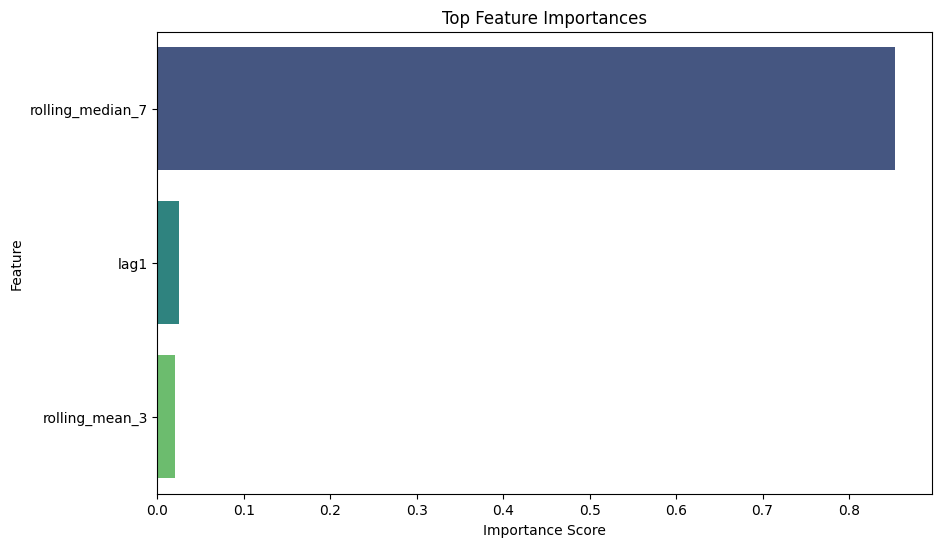

Random Forest - Validation MSE for dataset 12: 0.0721 and RMSE: 0.2686
XGBoost - Validation MSE for dataset 12: 0.0721 and RMSE: 0.2685
Ensemble - Validation MSE for dataset 12: 0.0702 and RMSE: 0.2650
{'rf_prediction': 0.8792395898475374, 'xgb_prediction': 0.85401505, 'Prediction': 0.8666273210830552}


In [11]:
# request_body = {
#     "dataset_id": 446,
#     "values": [
#         {"timestamp": "2021-08-12T08:00:00", "value": 0.771170894},
#         {"timestamp": "2021-08-12T16:00:00", "value": -0.220975865},
#         {"timestamp": "2021-08-13T00:00:00", "value": 0.193082153},
#         {"timestamp": "2021-08-13T08:00:00", "value": 0.712193394},
#         {"timestamp": "2021-08-13T16:00:00", "value": 0.729504174},
#         {"timestamp": "2021-08-14T00:00:00", "value": 0.251087061},
#         {"timestamp": "2021-08-14T08:00:00", "value": 0.821731142},
#         {"timestamp": "2021-08-14T16:00:00", "value": -0.175981108},
#         {"timestamp": "2021-08-15T00:00:00", "value": 0.274852229},
#         {"timestamp": "2021-08-15T08:00:00", "value": 0.849108289},
#         {"timestamp": "2021-08-15T16:00:00", "value": -0.191936872},
#         {"timestamp": "2021-08-16T00:00:00", "value": 0.325933535},
#         {"timestamp": "2021-08-16T08:00:00", "value": 0.731275204},
#         {"timestamp": "2021-08-16T16:00:00", "value": -0.158743049},
#         {"timestamp": "2021-08-17T00:00:00", "value": 0.347292397},
#         {"timestamp": "2021-08-17T08:00:00", "value": 0.832695031}
#         # {"timestamp": "2021-08-17T16:00:00", "value": -0.167526833}
#         # {"timestamp": "2021-08-18T00:00:00", "value": 0.372266877},
#         # {"timestamp": "2021-08-18T08:00:00", "value": 0.855515774},
#         # {"timestamp": "2021-08-18T16:00:00", "value": -0.124391301},
#         # {"timestamp": "2021-08-19T00:00:00", "value": 0.346138974},
#         # {"timestamp": "2021-08-19T08:00:00", "value": 0.932784134}
#     ]
# }




# request_body = {
#     "dataset_id": 9,
#     "values": [
#         {"timestamp": "2021-12-16T00:00:00", "value": -0.983261433},
#         {"timestamp": "2021-12-16T00:10:00", "value": -0.91107803},
#         {"timestamp": "2021-12-16T00:20:00", "value": -1.156429563},
#         {"timestamp": "2021-12-16T00:30:00", "value": -1.10284282},
#         {"timestamp": "2021-12-16T00:40:00", "value": -0.961654824},
#         {"timestamp": "2021-12-16T00:50:00", "value": -0.815019224},
#         {"timestamp": "2021-12-16T01:00:00", "value": -0.86641369},
#         {"timestamp": "2021-12-16T01:10:00", "value": -0.97474556}
#         # {"timestamp": "2021-12-16T01:20:00", "value": -0.987190645},
#         # {"timestamp": "2021-12-16T01:30:00", "value": -1.012407486},
#         # {"timestamp": "2021-12-16T01:40:00", "value": -1.073529946}
#         # {"timestamp": "2021-12-16T01:50:00", "value": -0.875429128}
#         # {"timestamp": "2021-12-16T02:00:00", "value": -1.082315529}
#         # {"timestamp": "2021-12-16T02:10:00", "value": -1.014878256}
#         # {"timestamp": "2021-12-16T02:20:00", "value": -1.031892358}
#     ]
# }


request_body = {
    "dataset_id": 12,
    "values": [
        {"timestamp": "2021-11-04T00:00:00", "value": 0.944603555},
        {"timestamp": "2021-11-04T00:10:00", "value": 0.829165996},
        {"timestamp": "2021-11-04T00:20:00", "value": -0.261614758},
        {"timestamp": "2021-11-04T00:30:00", "value": 0.859489606},
        {"timestamp": "2021-11-04T00:40:00", "value": 0.844343196},
        {"timestamp": "2021-11-04T00:50:00", "value": 1.066710334},
        {"timestamp": "2021-11-04T01:00:00", "value": 0.92159333},
        {"timestamp": "2021-11-04T01:10:00", "value": 0.811575586}
        # {"timestamp": "2021-11-04T01:20:00", "value": 0.954893683}
        # {"timestamp": "2021-11-04T01:30:00", "value": 1.049988906},
        # {"timestamp": "2021-11-04T01:40:00", "value": 1.003947348},
        # {"timestamp": "2021-11-04T01:50:00", "value": 1.147498616},
        # {"timestamp": "2021-11-04T02:00:00", "value": 0.963893364}
        # {"timestamp": "2021-11-04T02:10:00", "value": 1.046579276}
        # {"timestamp": "2021-11-04T02:20:00", "value": 1.053481119}
    ]
}


# Use the dataset_id from the request body
dataset_id = request_body["dataset_id"]
train_path= r'E:\Assignments\Time Series\Data_splits\train_splits'
test_path= r'E:\Assignments\Time Series\Data_splits\test_splits'

# Train the model
predict_next_value = train_model(dataset_id, train_dir=train_path, test_dir=test_path)

# Call prediction function
response = predict_next_value(request_body)

print(response)

# Saving Model

In [12]:
import os
import re

directory = r'E:\Assignments\Time Series\Data_splits\train_splits'

numbers = []

for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        number = re.findall(r'\d+', filename)
        if number:
            numbers.extend(map(int, number))

sorted_nums = sorted(numbers)
print("Extracted numbers:", sorted_nums)

Extracted numbers: [9, 12, 21, 23, 29, 39, 42, 43, 66, 74, 75, 79, 92, 102, 103, 105, 110, 115, 118, 119, 131, 141, 151, 153, 155, 161, 165, 176, 177, 185, 188, 198, 200, 204, 205, 209, 211, 212, 217, 218, 227, 242, 246, 251, 256, 272, 287, 290, 294, 297, 300, 301, 306, 310, 314, 321, 325, 335, 338, 348, 352, 354, 361, 367, 370, 383, 386, 391, 397, 401, 421, 428, 429, 430, 435, 437, 439, 440, 446, 447, 451, 453, 461, 462, 465, 469, 482, 483, 490, 491, 495, 498, 499, 505, 506, 507]


Top 3 features importance:
            Feature  Importance
0     rolling_min_7    0.612396
1  rolling_median_7    0.073384
2    rolling_mean_3    0.064494


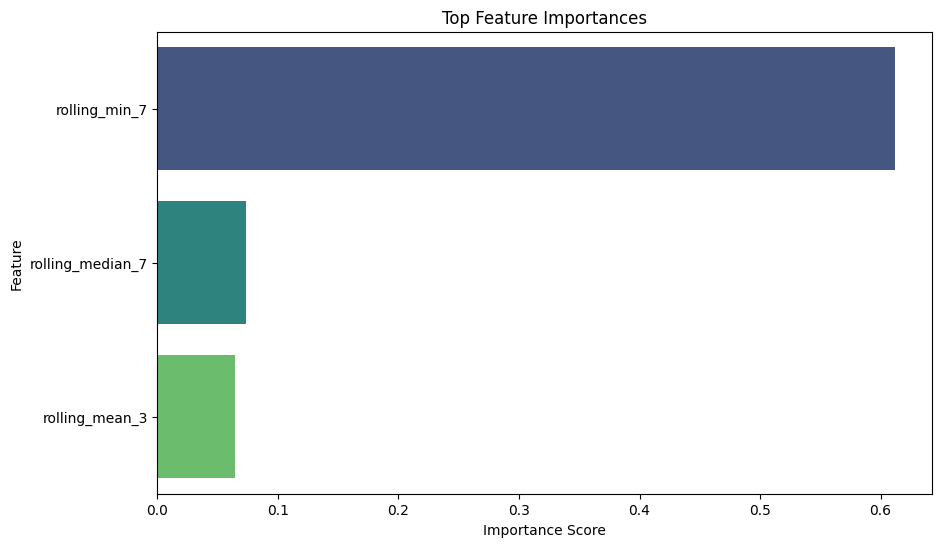

Random Forest - Validation MSE for dataset 9: 0.0131, RMSE: 0.1145
XGBoost - Validation MSE for dataset 9: 0.0140, RMSE: 0.1185
Models saved for dataset 9 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 9: 0.0134, RMSE: 0.1156
Top 3 features importance:
          Feature  Importance
0            lag1    0.865357
1  rolling_mean_3    0.068979
2       dayofweek    0.017931


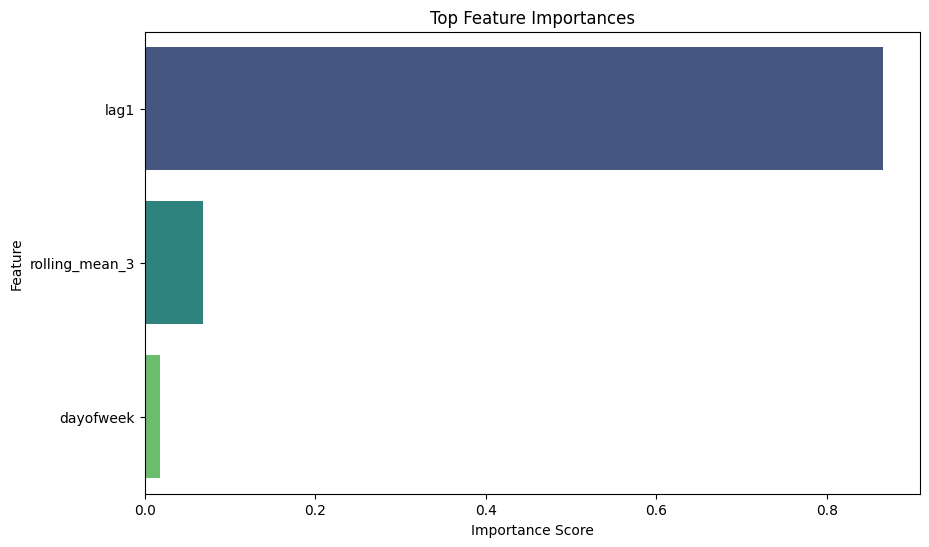

Random Forest - Validation MSE for dataset 12: 0.0181, RMSE: 0.1346
XGBoost - Validation MSE for dataset 12: 0.0195, RMSE: 0.1395
Models saved for dataset 12 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 12: 0.0180, RMSE: 0.1340
Top 3 features importance:
         Feature  Importance
0           lag1    0.998649
1           lag5    0.000164
2  rolling_max_7    0.000164


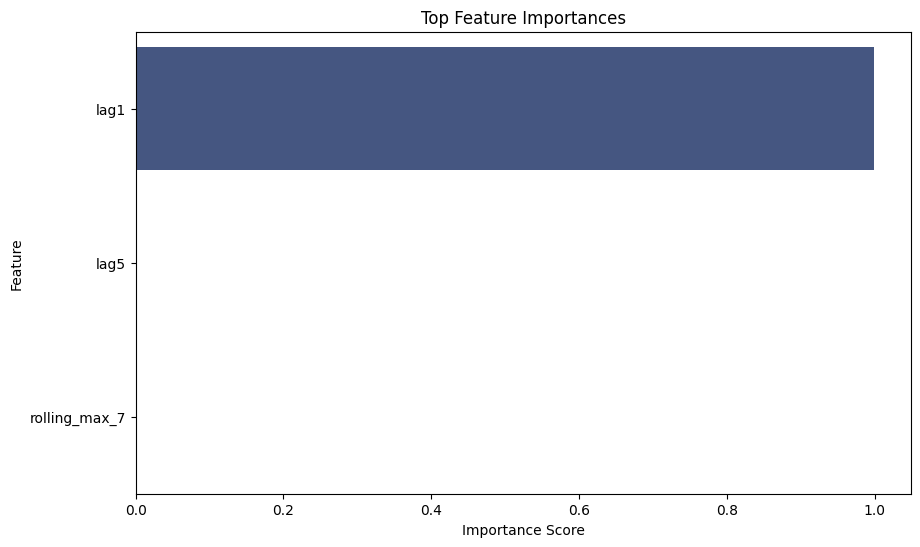

Random Forest - Validation MSE for dataset 21: 0.0007, RMSE: 0.0261
XGBoost - Validation MSE for dataset 21: 0.0007, RMSE: 0.0270
Models saved for dataset 21 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 21: 0.0003, RMSE: 0.0176
Top 3 features importance:
  Feature  Importance
0    lag1    0.989410
1    lag3    0.002048
2    lag2    0.001890


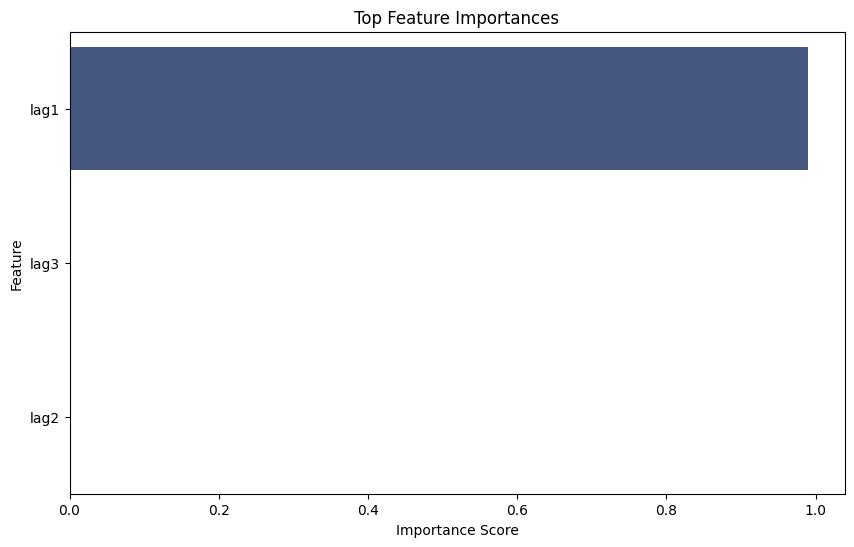

Random Forest - Validation MSE for dataset 23: 0.0040, RMSE: 0.0631
XGBoost - Validation MSE for dataset 23: 0.0049, RMSE: 0.0703
Models saved for dataset 23 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 23: 0.0036, RMSE: 0.0600
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.857539
1            lag1    0.060756
2   rolling_min_7    0.022366


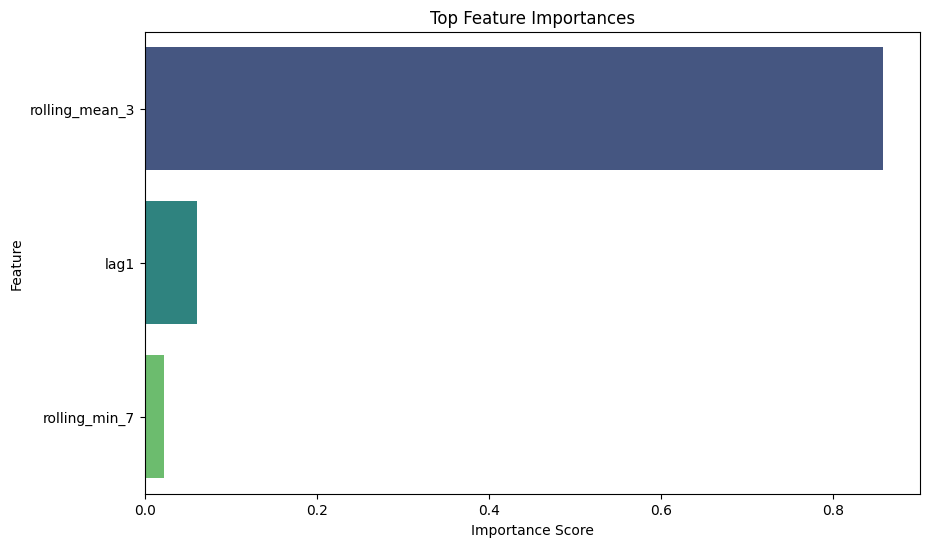

Random Forest - Validation MSE for dataset 29: 0.0108, RMSE: 0.1042
XGBoost - Validation MSE for dataset 29: 0.0118, RMSE: 0.1087
Models saved for dataset 29 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 29: 0.0111, RMSE: 0.1053
Top 3 features importance:
          Feature  Importance
0            lag1    0.834704
1  rolling_mean_3    0.069973
2   rolling_max_7    0.038100


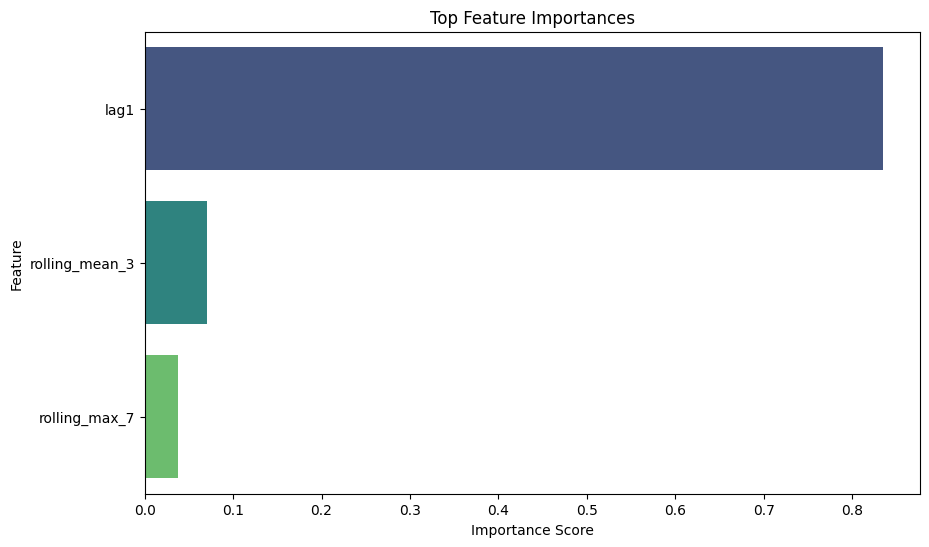

Random Forest - Validation MSE for dataset 39: 0.0174, RMSE: 0.1317
XGBoost - Validation MSE for dataset 39: 0.0187, RMSE: 0.1368
Models saved for dataset 39 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 39: 0.0164, RMSE: 0.1282
Top 3 features importance:
         Feature  Importance
0           lag1    0.993566
1           lag3    0.001228
2  rolling_std_3    0.001171


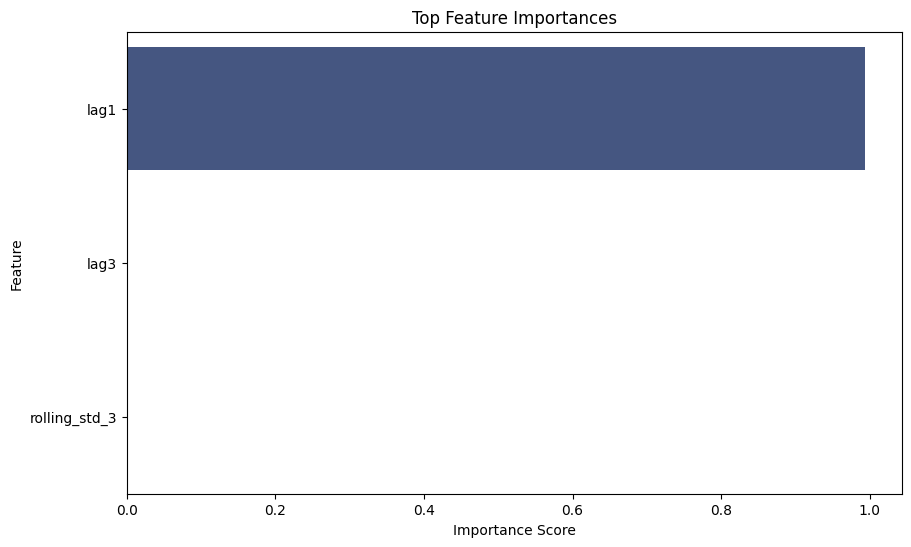

Random Forest - Validation MSE for dataset 42: 0.0008, RMSE: 0.0288
XGBoost - Validation MSE for dataset 42: 0.0005, RMSE: 0.0228
Models saved for dataset 42 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 42: 0.0006, RMSE: 0.0239
Top 3 features importance:
  Feature  Importance
0    lag1    0.993244
1    lag3    0.001027
2    lag2    0.000935


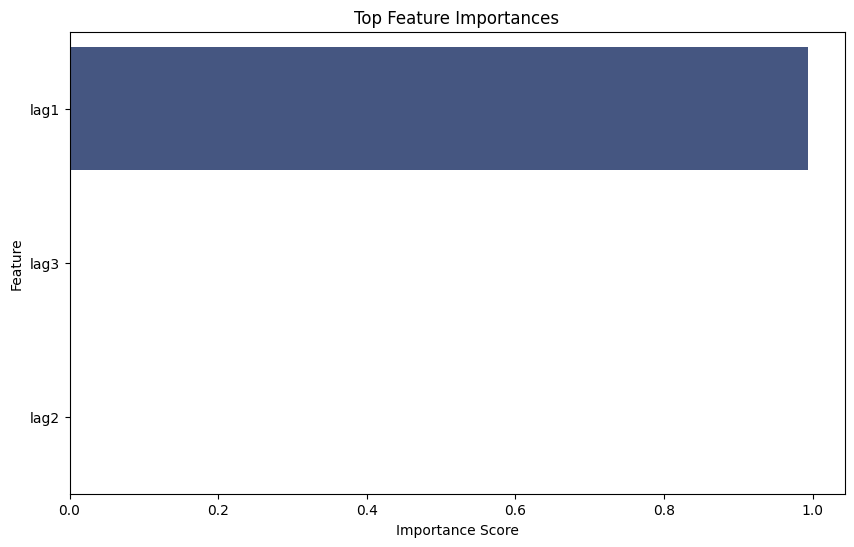

Random Forest - Validation MSE for dataset 43: 0.0014, RMSE: 0.0370
XGBoost - Validation MSE for dataset 43: 0.0010, RMSE: 0.0320
Models saved for dataset 43 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 43: 0.0011, RMSE: 0.0331
Top 3 features importance:
         Feature  Importance
0           lag1    0.998895
1  rolling_max_7    0.000215
2  rolling_min_7    0.000208


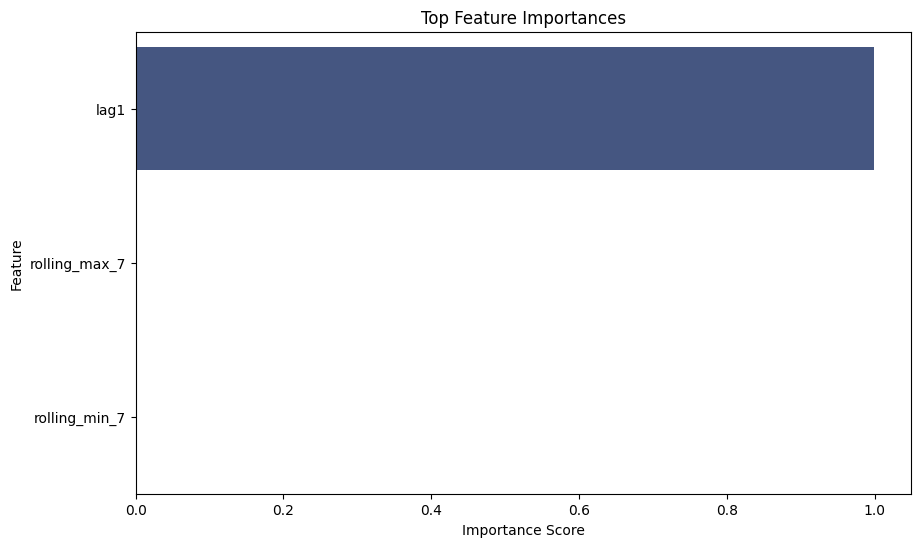

Random Forest - Validation MSE for dataset 66: 0.0002, RMSE: 0.0135
XGBoost - Validation MSE for dataset 66: 0.0001, RMSE: 0.0121
Models saved for dataset 66 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 66: 0.0001, RMSE: 0.0119
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.777299
1            lag1    0.055759
2   rolling_max_7    0.047406


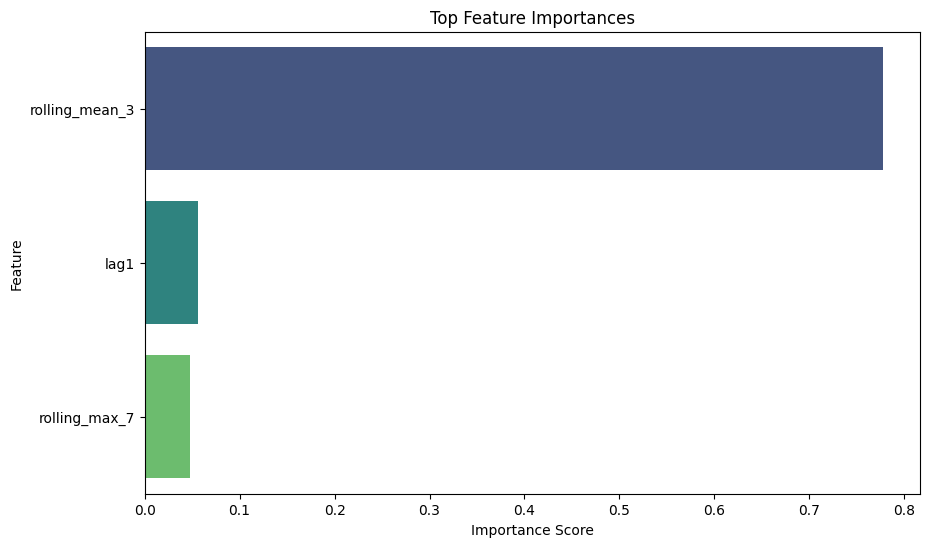

Random Forest - Validation MSE for dataset 74: 0.0503, RMSE: 0.2242
XGBoost - Validation MSE for dataset 74: 0.0542, RMSE: 0.2327
Models saved for dataset 74 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 74: 0.0502, RMSE: 0.2240
Top 3 features importance:
         Feature  Importance
0           lag1    0.995138
1           lag3    0.000657
2  rolling_max_7    0.000639


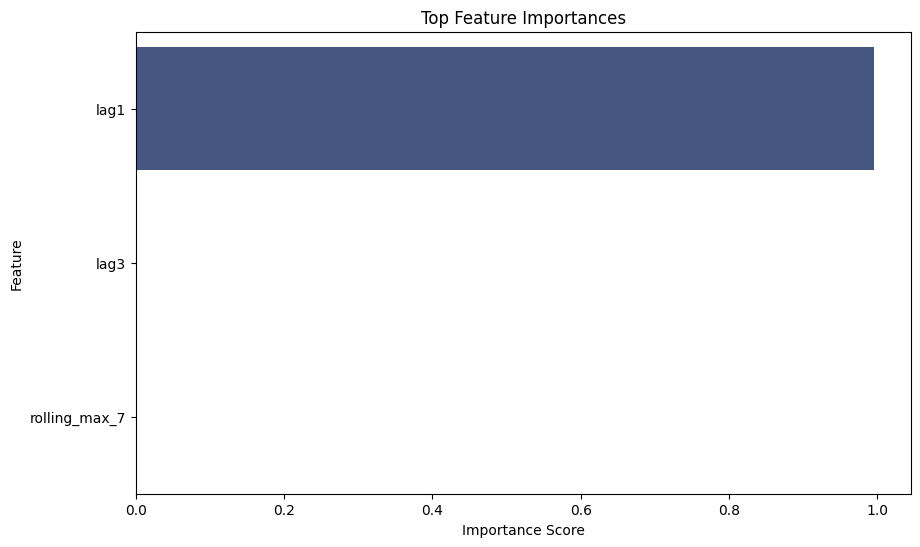

Random Forest - Validation MSE for dataset 75: 0.0030, RMSE: 0.0545
XGBoost - Validation MSE for dataset 75: 0.0013, RMSE: 0.0367
Models saved for dataset 75 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 75: 0.0018, RMSE: 0.0425
Top 3 features importance:
         Feature  Importance
0           lag1    0.990102
1  rolling_min_7    0.001368
2           lag3    0.001320


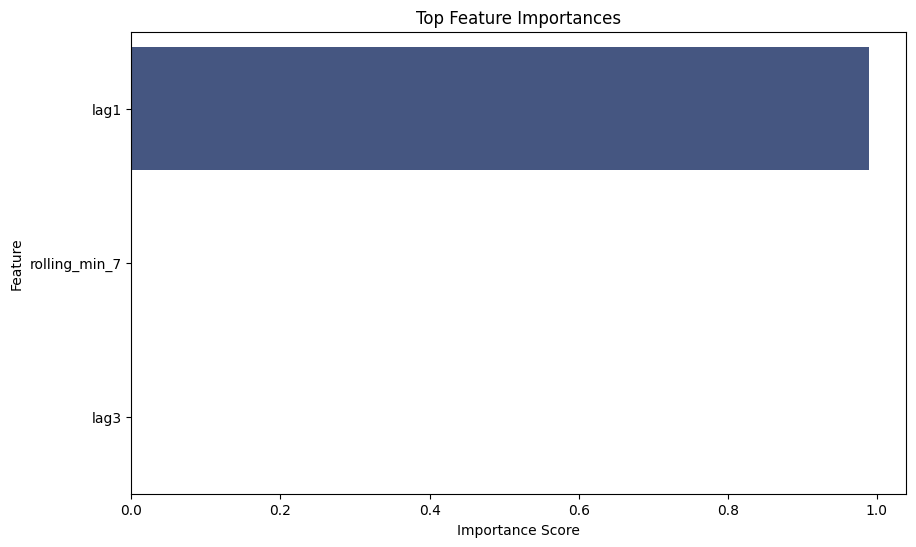

Random Forest - Validation MSE for dataset 79: 0.0057, RMSE: 0.0758
XGBoost - Validation MSE for dataset 79: 0.0039, RMSE: 0.0622
Models saved for dataset 79 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 79: 0.0041, RMSE: 0.0640
Top 3 features importance:
         Feature  Importance
0           lag1    0.991028
1  rolling_std_3    0.001499
2  rolling_max_7    0.001198


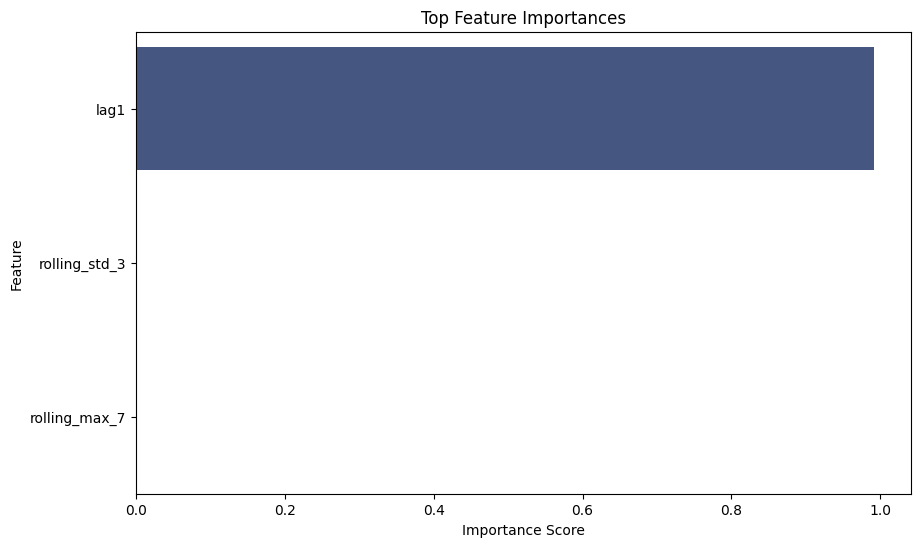

Random Forest - Validation MSE for dataset 92: 0.0012, RMSE: 0.0340
XGBoost - Validation MSE for dataset 92: 0.0011, RMSE: 0.0326
Models saved for dataset 92 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 92: 0.0010, RMSE: 0.0316
Top 3 features importance:
         Feature  Importance
0           lag1    0.999055
1  rolling_max_7    0.000167
2  rolling_min_7    0.000164


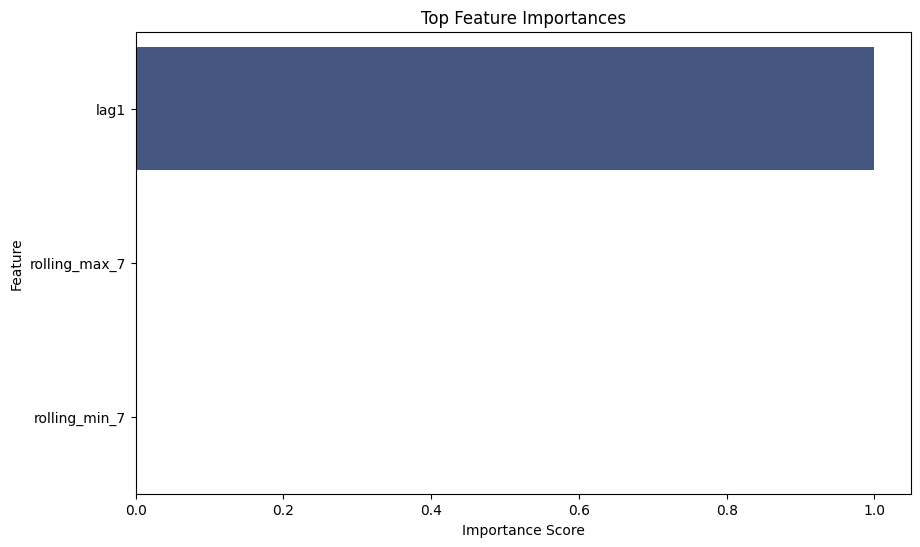

Random Forest - Validation MSE for dataset 102: 0.0000, RMSE: 0.0066
XGBoost - Validation MSE for dataset 102: 0.0000, RMSE: 0.0051
Models saved for dataset 102 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 102: 0.0000, RMSE: 0.0050
Top 3 features importance:
  Feature  Importance
0    lag1    0.991895
1    lag3    0.001188
2    hour    0.000994


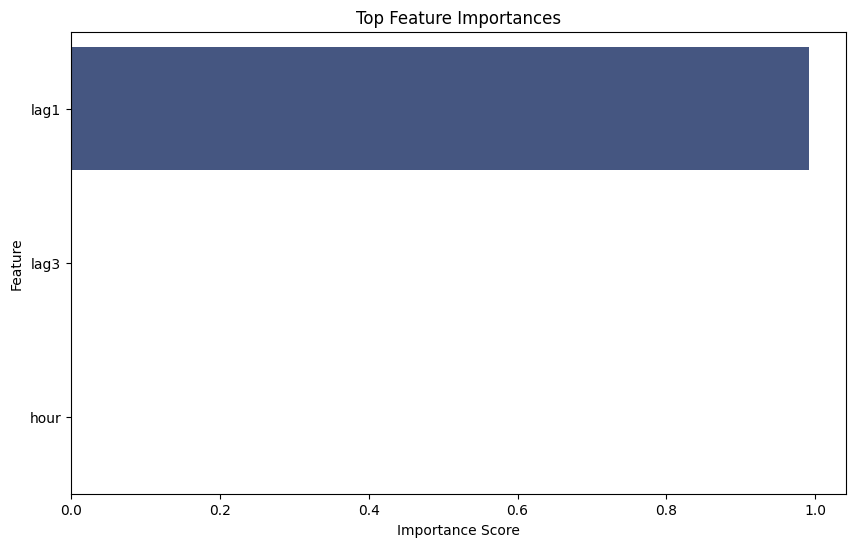

Random Forest - Validation MSE for dataset 103: 0.0062, RMSE: 0.0790
XGBoost - Validation MSE for dataset 103: 0.0027, RMSE: 0.0521
Models saved for dataset 103 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 103: 0.0037, RMSE: 0.0611
Top 3 features importance:
         Feature  Importance
0           lag1    0.998334
1  rolling_min_7    0.000330
2  rolling_max_7    0.000284


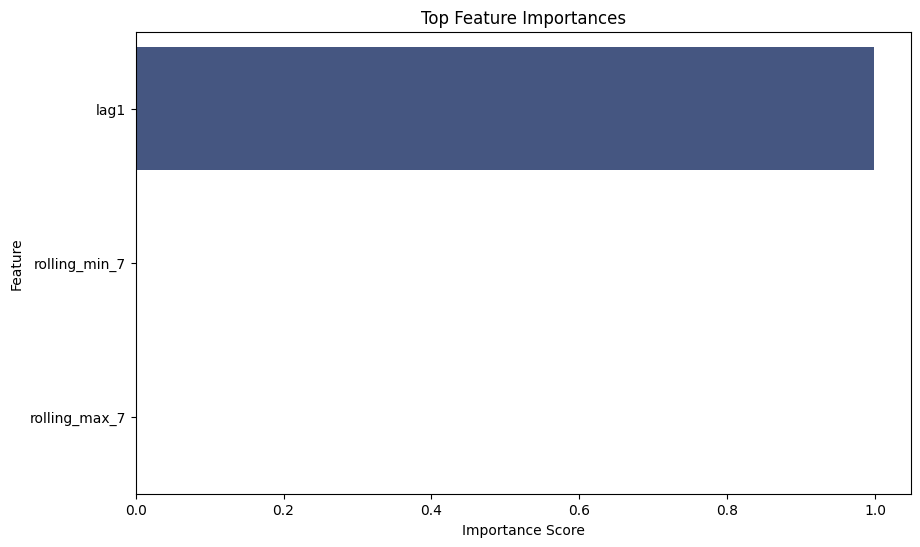

Random Forest - Validation MSE for dataset 105: 0.0001, RMSE: 0.0113
XGBoost - Validation MSE for dataset 105: 0.0002, RMSE: 0.0128
Models saved for dataset 105 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 105: 0.0001, RMSE: 0.0098
Top 3 features importance:
         Feature  Importance
0           lag1    0.993316
1           lag3    0.001000
2  rolling_std_3    0.000899


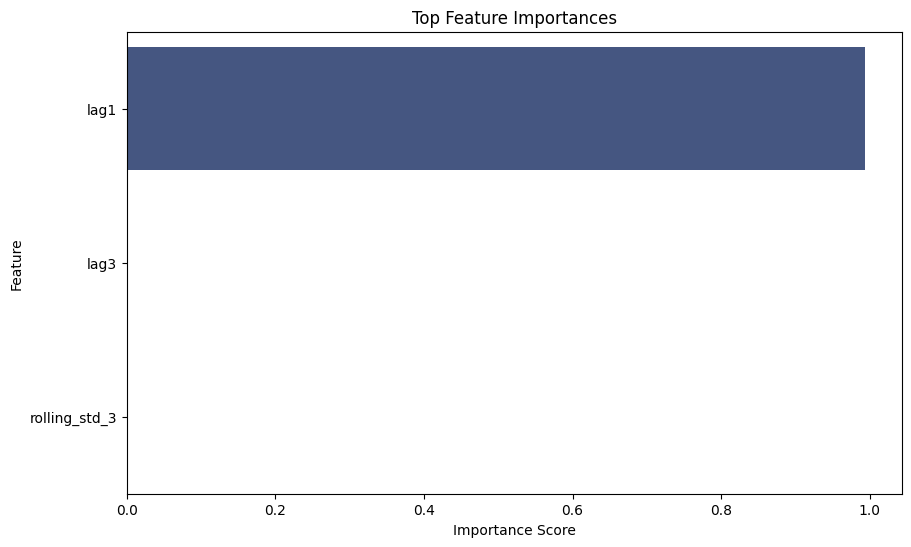

Random Forest - Validation MSE for dataset 110: 0.0017, RMSE: 0.0416
XGBoost - Validation MSE for dataset 110: 0.0011, RMSE: 0.0338
Models saved for dataset 110 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 110: 0.0013, RMSE: 0.0360
Top 3 features importance:
         Feature  Importance
0           lag1    0.993718
1  rolling_std_3    0.001080
2  rolling_max_7    0.000746


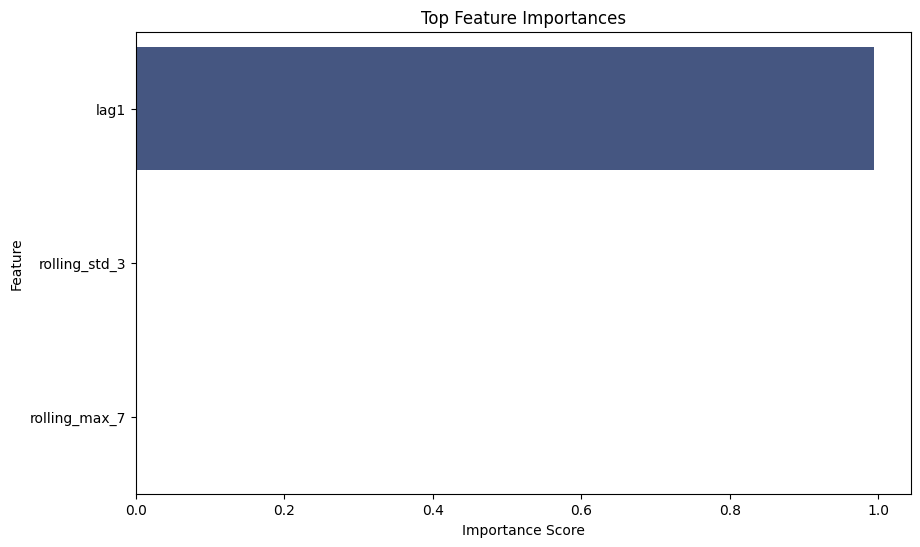

Random Forest - Validation MSE for dataset 115: 0.0016, RMSE: 0.0403
XGBoost - Validation MSE for dataset 115: 0.0010, RMSE: 0.0320
Models saved for dataset 115 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 115: 0.0012, RMSE: 0.0341
Top 3 features importance:
          Feature  Importance
0            lag1    0.796901
1  rolling_mean_3    0.069131
2   rolling_max_7    0.050835


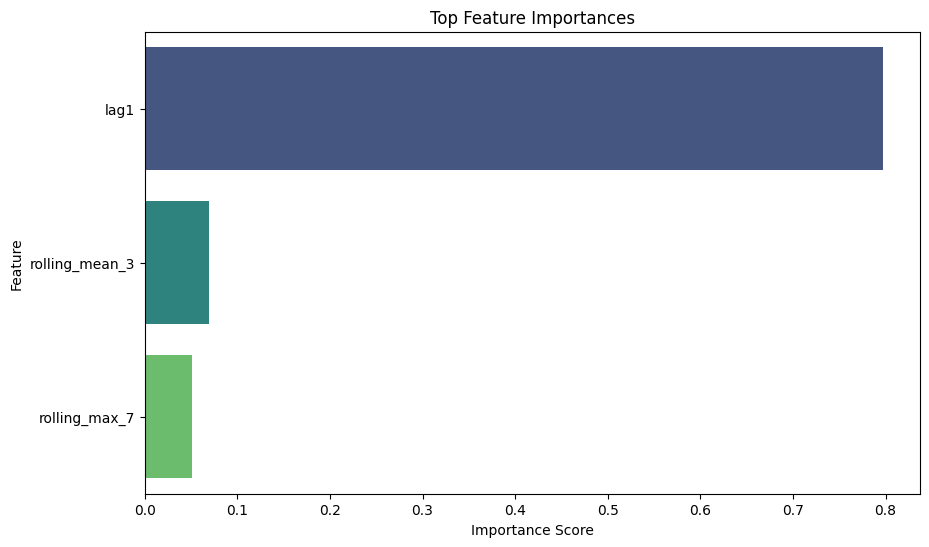

Random Forest - Validation MSE for dataset 118: 0.0969, RMSE: 0.3113
XGBoost - Validation MSE for dataset 118: 0.0916, RMSE: 0.3027
Models saved for dataset 118 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 118: 0.0930, RMSE: 0.3050
Top 3 features importance:
         Feature  Importance
0           lag1    0.998371
1  rolling_max_7    0.000276
2           hour    0.000211


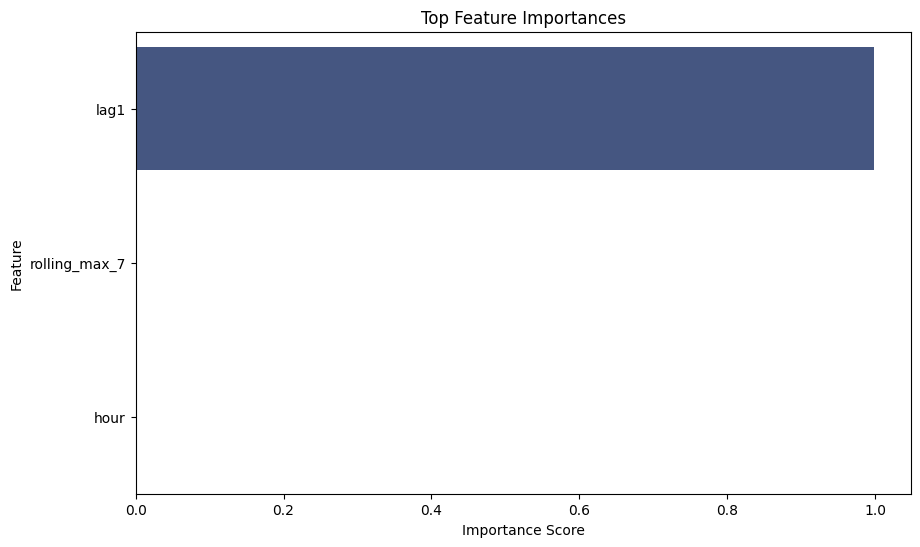

Random Forest - Validation MSE for dataset 119: 0.0005, RMSE: 0.0234
XGBoost - Validation MSE for dataset 119: 0.0001, RMSE: 0.0098
Models saved for dataset 119 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 119: 0.0002, RMSE: 0.0137
Top 3 features importance:
            Feature  Importance
0  rolling_median_7    0.560215
1             trend    0.124616
2    rolling_mean_3    0.041163


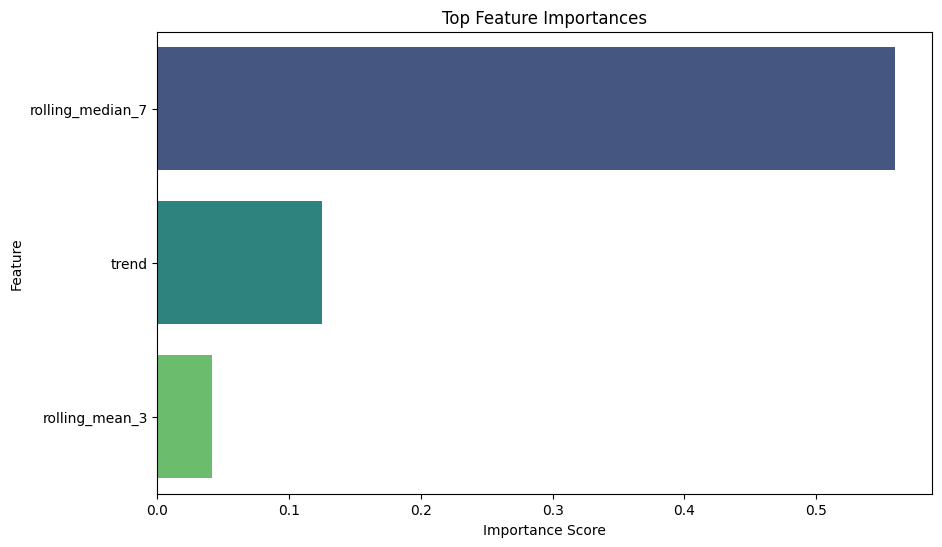

Random Forest - Validation MSE for dataset 131: 0.2291, RMSE: 0.4787
XGBoost - Validation MSE for dataset 131: 0.1248, RMSE: 0.3533
Models saved for dataset 131 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 131: 0.1700, RMSE: 0.4123
Top 3 features importance:
  Feature  Importance
0    lag1    0.983095
1    lag5    0.002923
2    lag3    0.002219


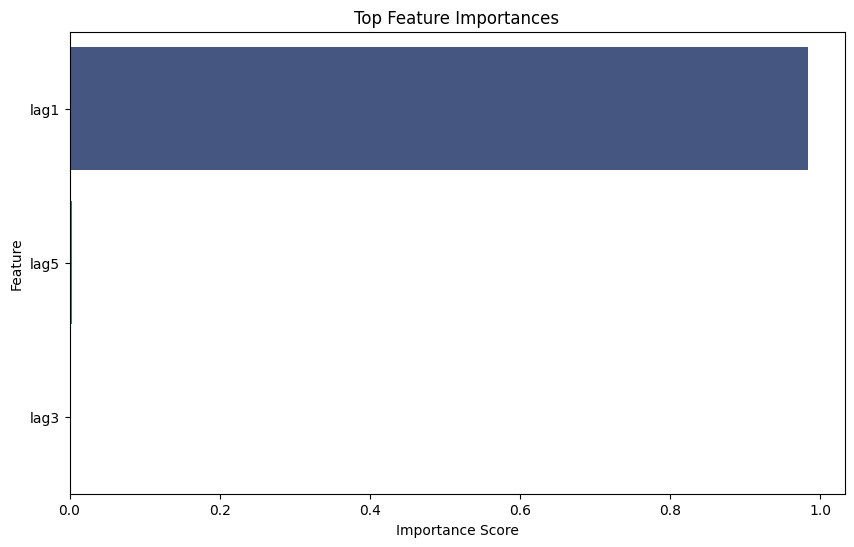

Random Forest - Validation MSE for dataset 141: 0.0017, RMSE: 0.0413
XGBoost - Validation MSE for dataset 141: 0.0011, RMSE: 0.0331
Models saved for dataset 141 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 141: 0.0012, RMSE: 0.0341
Top 3 features importance:
         Feature  Importance
0           lag1    0.990690
1  rolling_std_3    0.001175
2          trend    0.001131


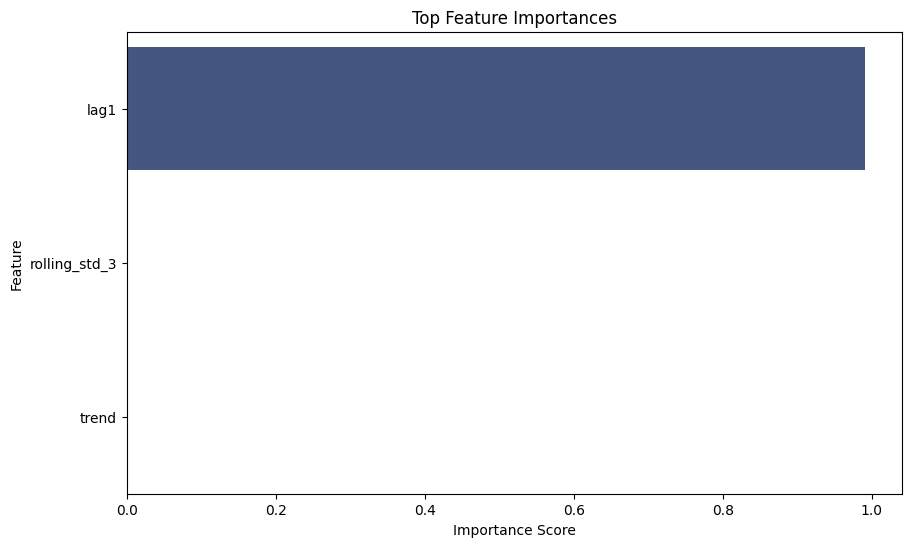

Random Forest - Validation MSE for dataset 151: 0.0301, RMSE: 0.1734
XGBoost - Validation MSE for dataset 151: 0.0058, RMSE: 0.0762
Models saved for dataset 151 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 151: 0.0147, RMSE: 0.1213
Top 3 features importance:
         Feature  Importance
0           lag1    0.992993
1          trend    0.001068
2  rolling_std_3    0.000834


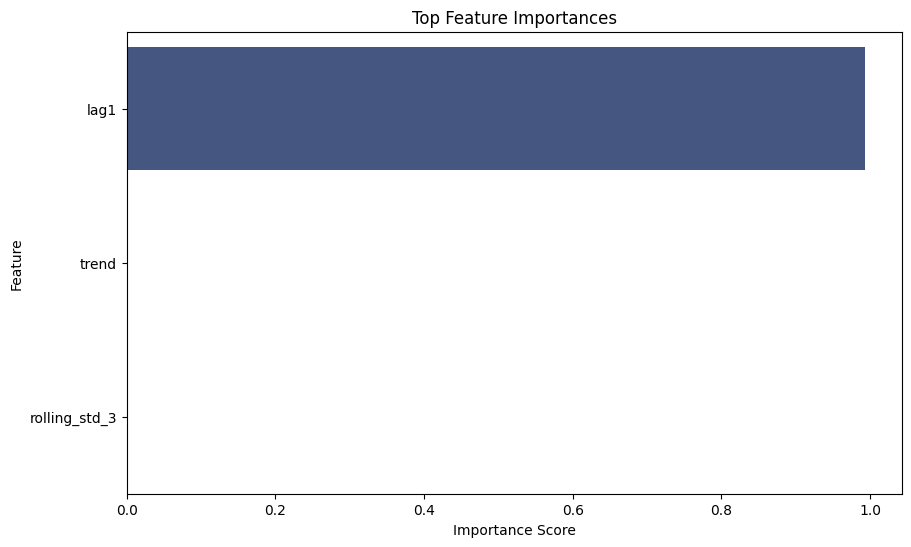

Random Forest - Validation MSE for dataset 153: 0.0143, RMSE: 0.1197
XGBoost - Validation MSE for dataset 153: 0.0071, RMSE: 0.0840
Models saved for dataset 153 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 153: 0.0101, RMSE: 0.1007
Top 3 features importance:
            Feature  Importance
0             trend    0.778682
1  rolling_median_7    0.178626
2    rolling_mean_3    0.012239


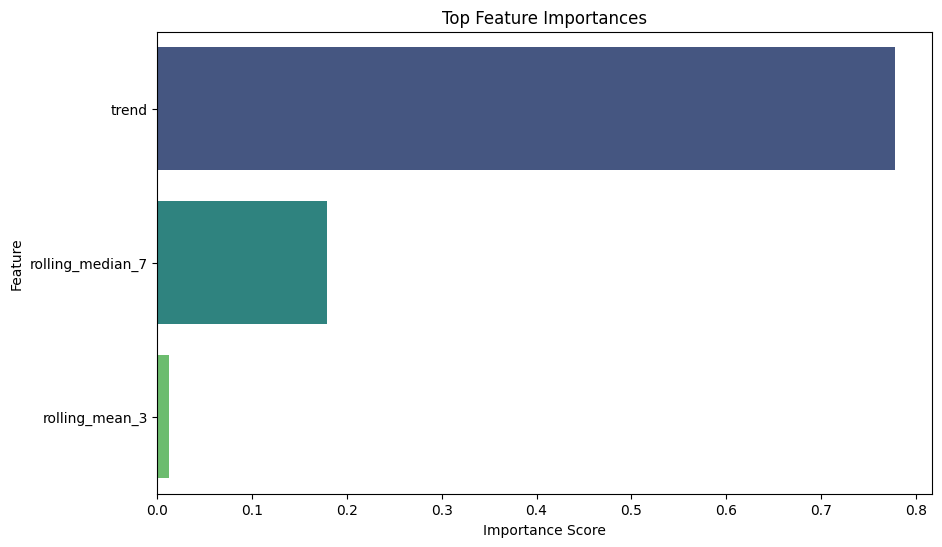

Random Forest - Validation MSE for dataset 155: 0.0129, RMSE: 0.1135
XGBoost - Validation MSE for dataset 155: 0.0430, RMSE: 0.2073
Models saved for dataset 155 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 155: 0.0247, RMSE: 0.1571
Top 3 features importance:
   Feature  Importance
0    trend    0.324224
1    month    0.291987
2  quarter    0.273563


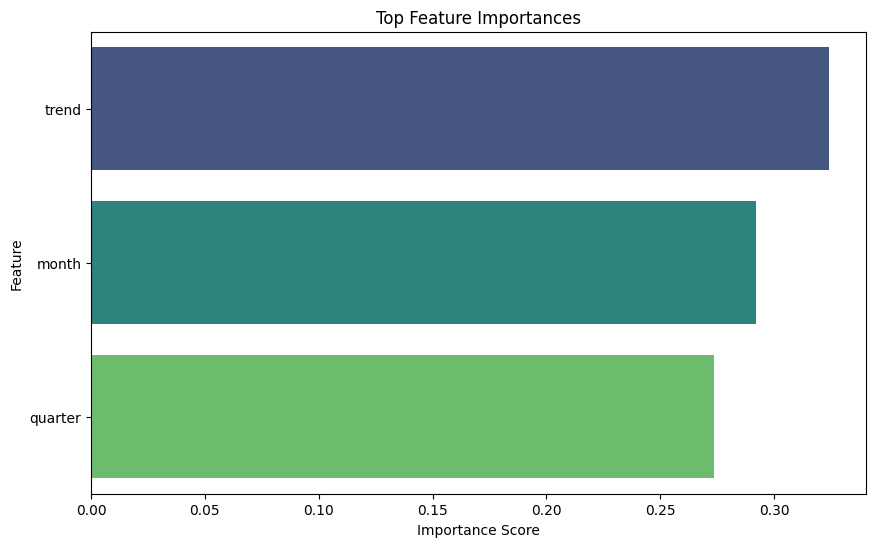

Random Forest - Validation MSE for dataset 161: 0.0760, RMSE: 0.2757
XGBoost - Validation MSE for dataset 161: 0.0758, RMSE: 0.2754
Models saved for dataset 161 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 161: 0.0759, RMSE: 0.2754
Top 3 features importance:
         Feature  Importance
0           lag1    0.967988
1           lag3    0.007485
2  rolling_std_3    0.004820


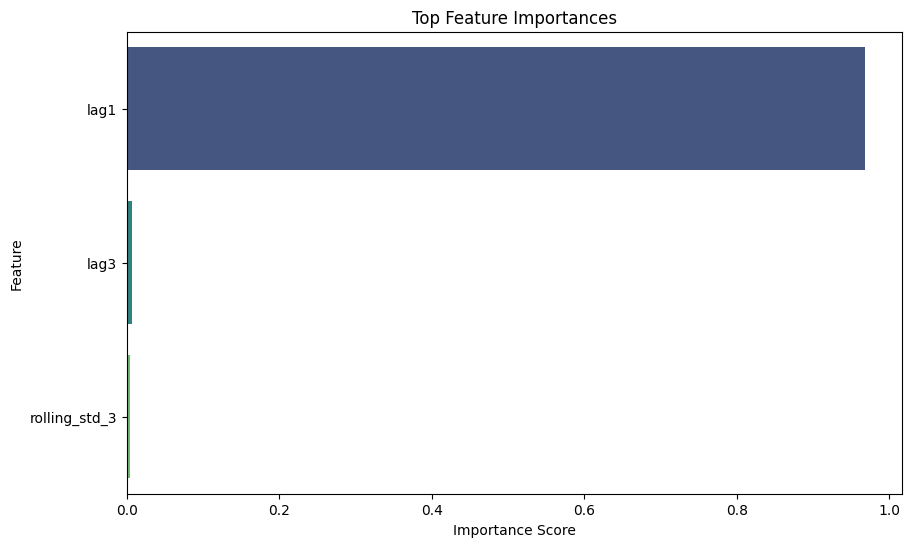

Random Forest - Validation MSE for dataset 165: 0.0056, RMSE: 0.0751
XGBoost - Validation MSE for dataset 165: 0.0045, RMSE: 0.0668
Models saved for dataset 165 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 165: 0.0049, RMSE: 0.0697
Top 3 features importance:
          Feature  Importance
0            lag1    0.996359
1  rolling_mean_3    0.000784
2   rolling_min_7    0.000384


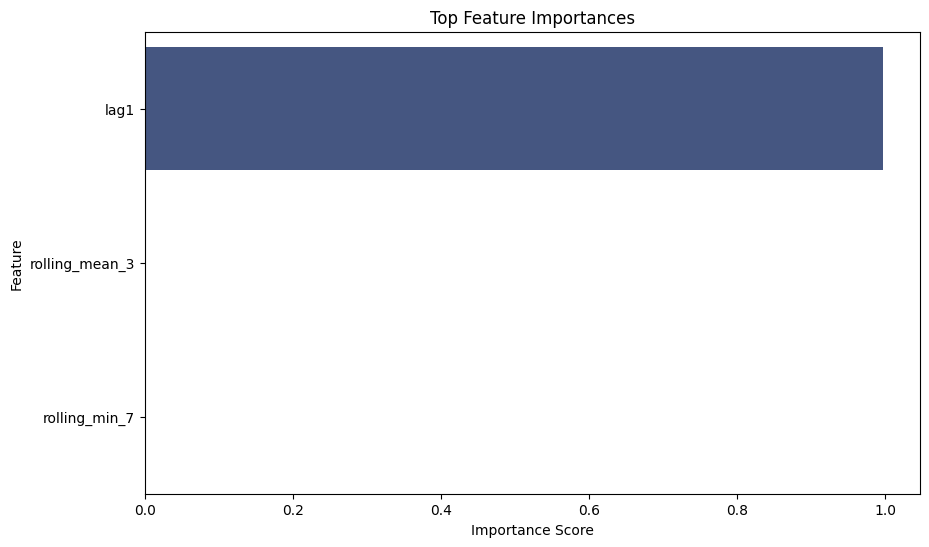

Random Forest - Validation MSE for dataset 176: 0.0027, RMSE: 0.0521
XGBoost - Validation MSE for dataset 176: 0.0021, RMSE: 0.0463
Models saved for dataset 176 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 176: 0.0022, RMSE: 0.0466
Top 3 features importance:
            Feature  Importance
0             trend    0.641041
1  rolling_median_7    0.302728
2     rolling_min_7    0.017079


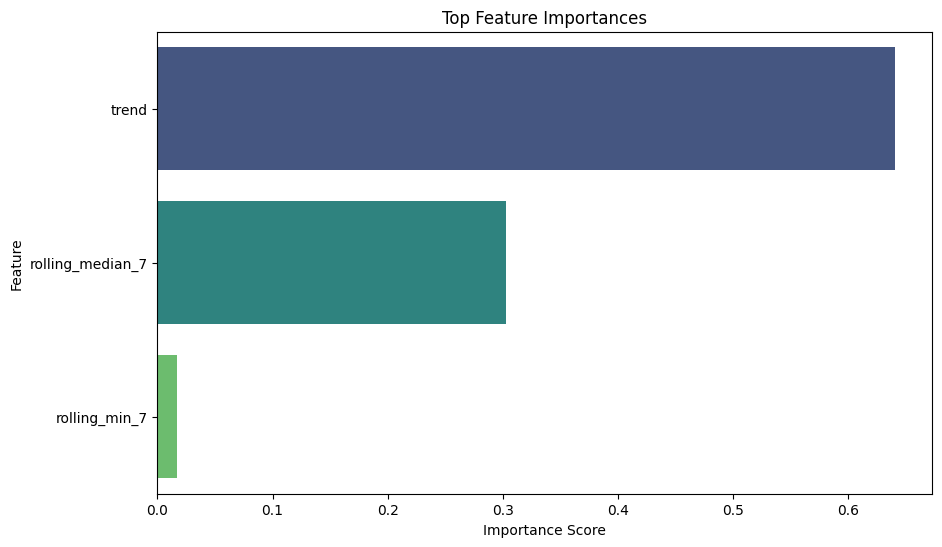

Random Forest - Validation MSE for dataset 177: 0.0224, RMSE: 0.1497
XGBoost - Validation MSE for dataset 177: 0.0616, RMSE: 0.2483
Models saved for dataset 177 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 177: 0.0363, RMSE: 0.1906
Top 3 features importance:
  Feature  Importance
0    lag1    0.983017
1    lag2    0.002455
2    lag3    0.002346


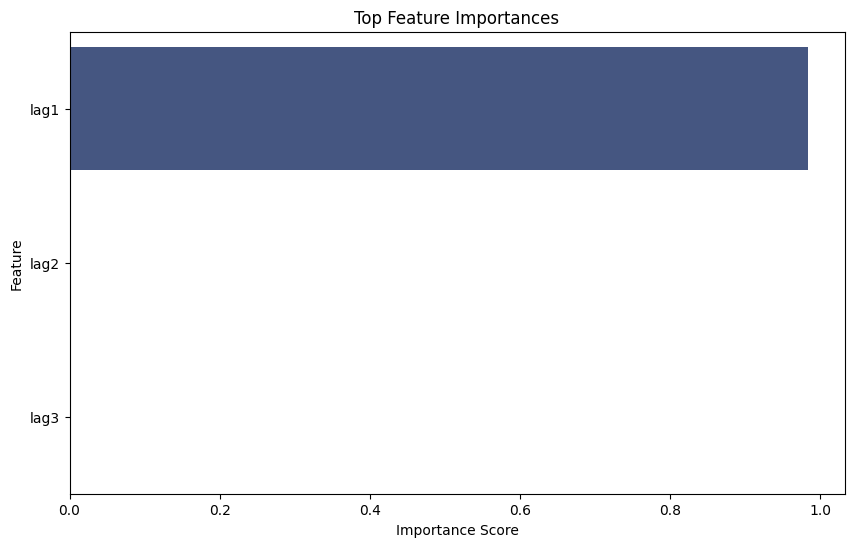

Random Forest - Validation MSE for dataset 185: 0.0028, RMSE: 0.0528
XGBoost - Validation MSE for dataset 185: 0.0062, RMSE: 0.0790
Models saved for dataset 185 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 185: 0.0033, RMSE: 0.0577
Top 3 features importance:
          Feature  Importance
0            lag1    0.995660
1  rolling_mean_3    0.003621
2           trend    0.000214


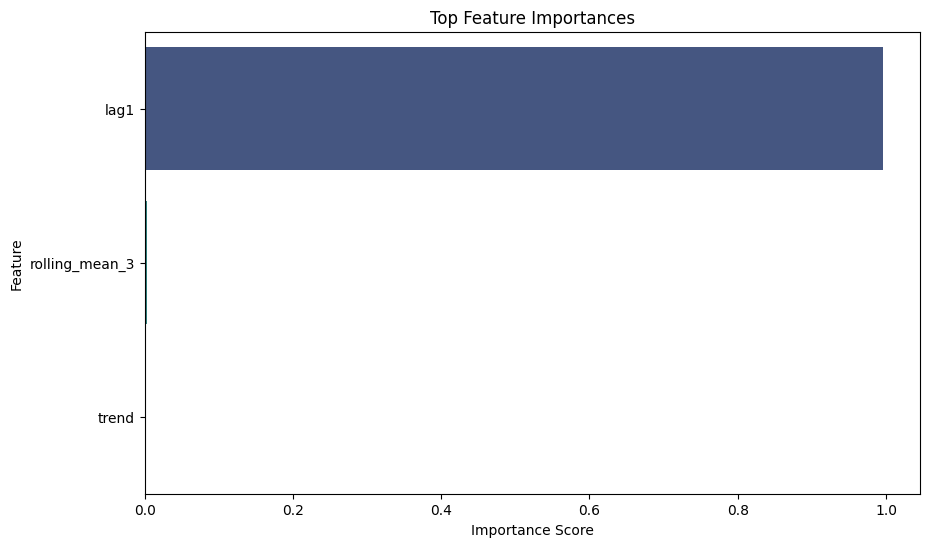

Random Forest - Validation MSE for dataset 188: 0.0188, RMSE: 0.1373
XGBoost - Validation MSE for dataset 188: 0.0048, RMSE: 0.0693
Models saved for dataset 188 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 188: 0.0102, RMSE: 0.1011
Top 3 features importance:
   Feature  Importance
0    month    0.348459
1  quarter    0.328910
2    trend    0.235176


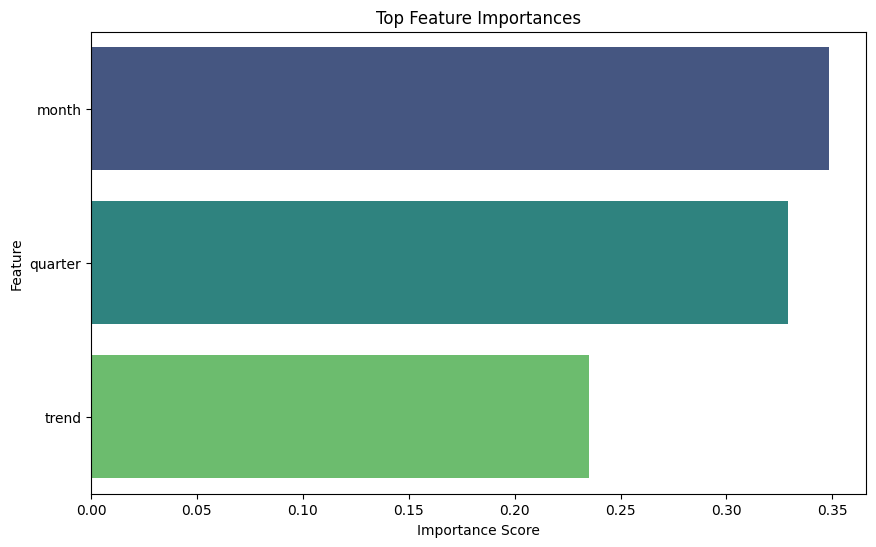

Random Forest - Validation MSE for dataset 198: 2.4120, RMSE: 1.5531
XGBoost - Validation MSE for dataset 198: 2.4154, RMSE: 1.5542
Models saved for dataset 198 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 198: 2.4137, RMSE: 1.5536
Top 3 features importance:
  Feature  Importance
0    lag5    0.101443
1    lag1    0.093645
2   trend    0.091467


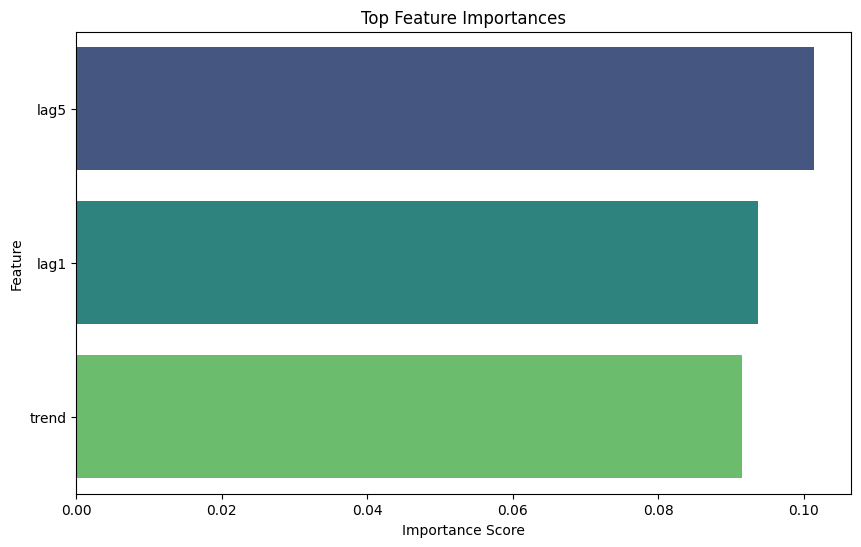

Random Forest - Validation MSE for dataset 200: 0.0180, RMSE: 0.1342
XGBoost - Validation MSE for dataset 200: 0.0166, RMSE: 0.1287
Models saved for dataset 200 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 200: 0.0165, RMSE: 0.1285
Top 3 features importance:
  Feature  Importance
0    lag1    0.996131
1    lag3    0.000668
2    lag2    0.000521


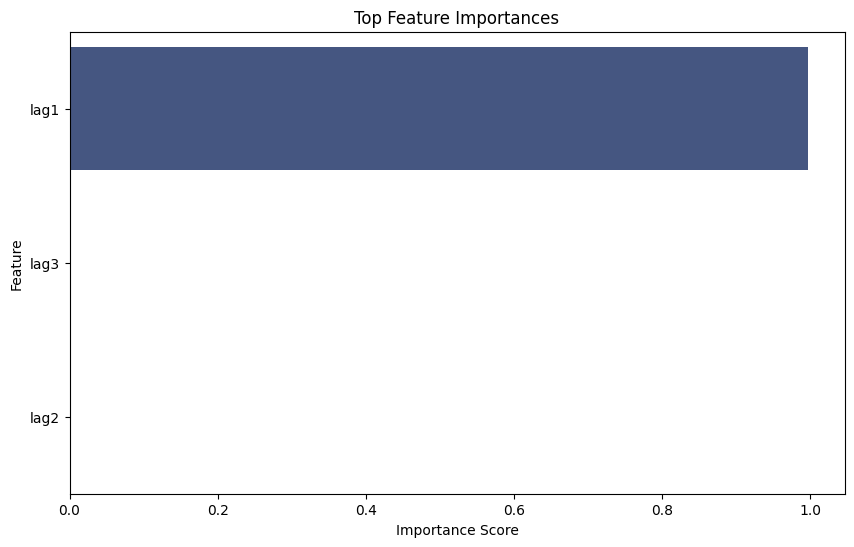

Random Forest - Validation MSE for dataset 204: 0.0043, RMSE: 0.0654
XGBoost - Validation MSE for dataset 204: 0.0052, RMSE: 0.0720
Models saved for dataset 204 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 204: 0.0043, RMSE: 0.0656
Top 3 features importance:
   Feature  Importance
0  quarter    0.472368
1    month    0.436022
2    trend    0.018595


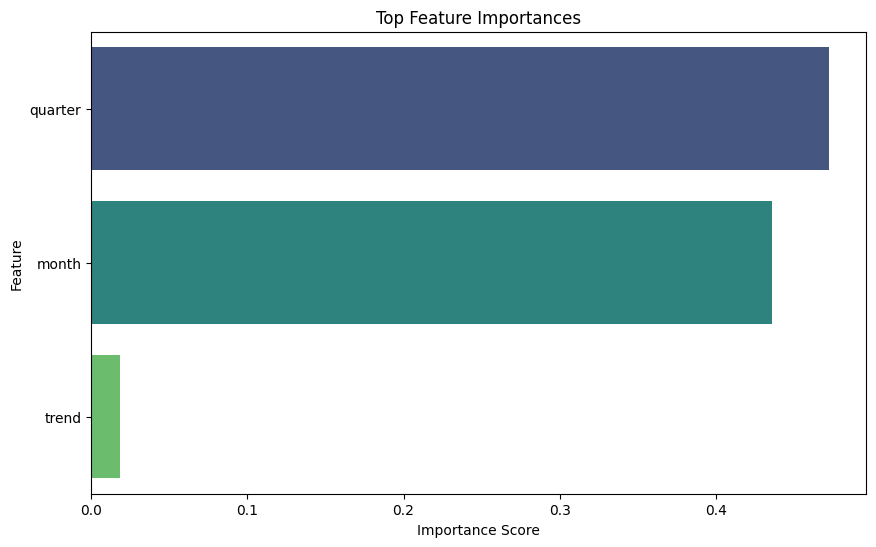

Random Forest - Validation MSE for dataset 205: 0.0370, RMSE: 0.1922
XGBoost - Validation MSE for dataset 205: 0.0082, RMSE: 0.0903
Models saved for dataset 205 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 205: 0.0149, RMSE: 0.1220
Top 3 features importance:
   Feature  Importance
0  quarter    0.368294
1    month    0.349337
2    trend    0.177524


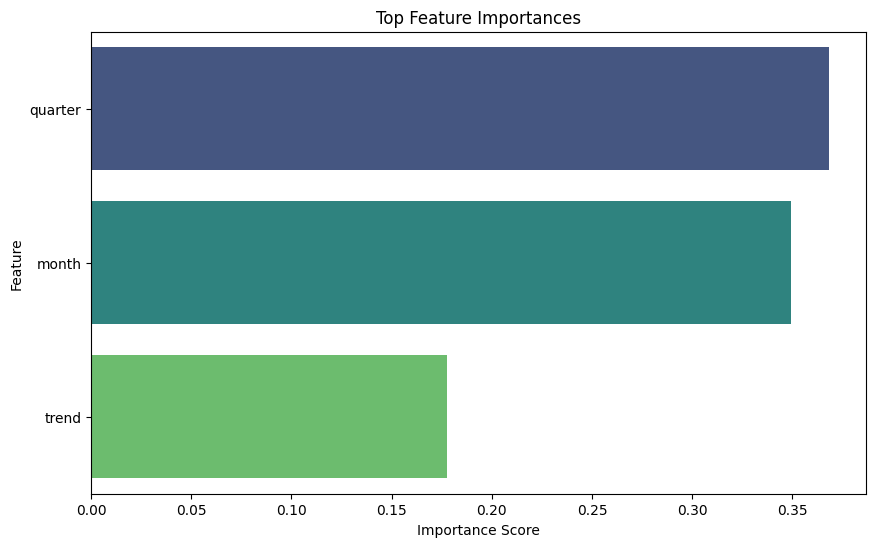

Random Forest - Validation MSE for dataset 209: 2.0697, RMSE: 1.4386
XGBoost - Validation MSE for dataset 209: 2.2262, RMSE: 1.4920
Models saved for dataset 209 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 209: 2.1467, RMSE: 1.4652
Top 3 features importance:
   Feature  Importance
0    month    0.433573
1  quarter    0.236481
2    trend    0.119553


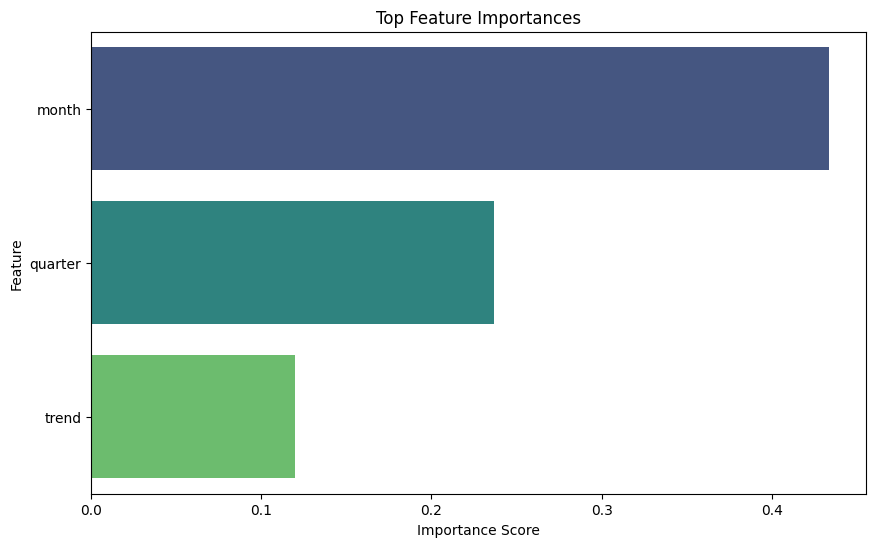

Random Forest - Validation MSE for dataset 211: 0.0147, RMSE: 0.1211
XGBoost - Validation MSE for dataset 211: 0.0135, RMSE: 0.1163
Models saved for dataset 211 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 211: 0.0137, RMSE: 0.1170
Top 3 features importance:
  Feature  Importance
0    lag3    0.109138
1    lag4    0.099407
2   trend    0.094576


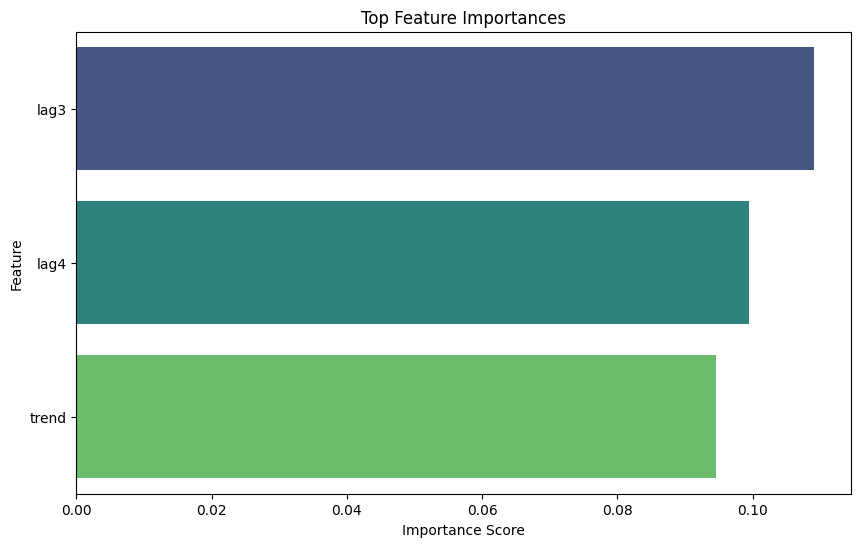

Random Forest - Validation MSE for dataset 212: 0.0403, RMSE: 0.2008
XGBoost - Validation MSE for dataset 212: 0.0483, RMSE: 0.2197
Models saved for dataset 212 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 212: 0.0427, RMSE: 0.2066
Top 3 features importance:
          Feature  Importance
0            lag1    0.960871
1  rolling_mean_3    0.037969
2   rolling_min_7    0.000299


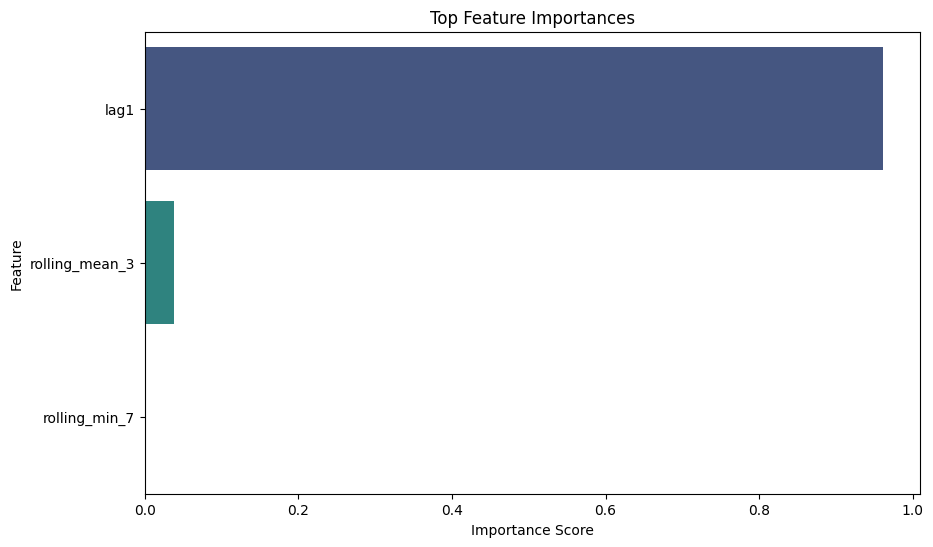

Random Forest - Validation MSE for dataset 217: 0.0124, RMSE: 0.1113
XGBoost - Validation MSE for dataset 217: 0.0098, RMSE: 0.0990
Models saved for dataset 217 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 217: 0.0110, RMSE: 0.1049
Top 3 features importance:
   Feature  Importance
0    month    0.367781
1  quarter    0.328803
2    trend    0.196702


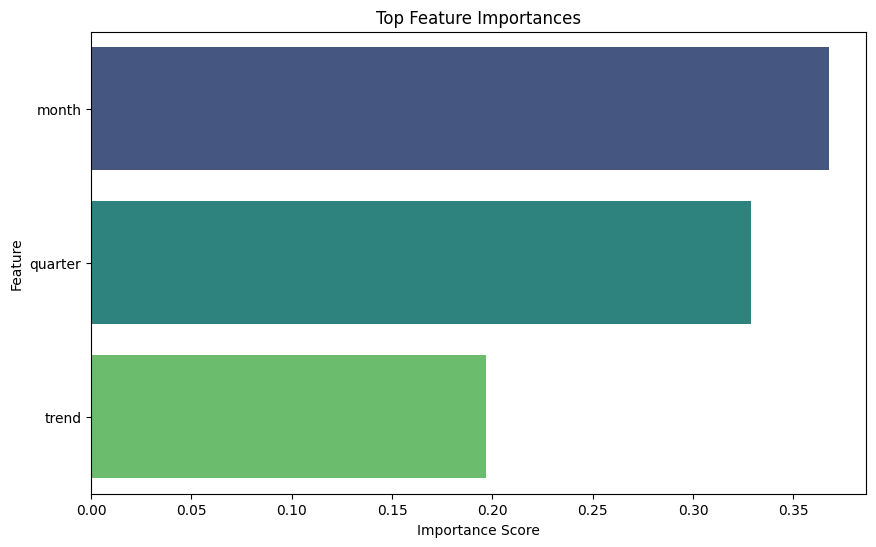

Random Forest - Validation MSE for dataset 218: 2.1937, RMSE: 1.4811
XGBoost - Validation MSE for dataset 218: 2.2497, RMSE: 1.4999
Models saved for dataset 218 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 218: 2.2216, RMSE: 1.4905
Top 3 features importance:
   Feature  Importance
0    month    0.581642
1  quarter    0.387807
2    trend    0.004027


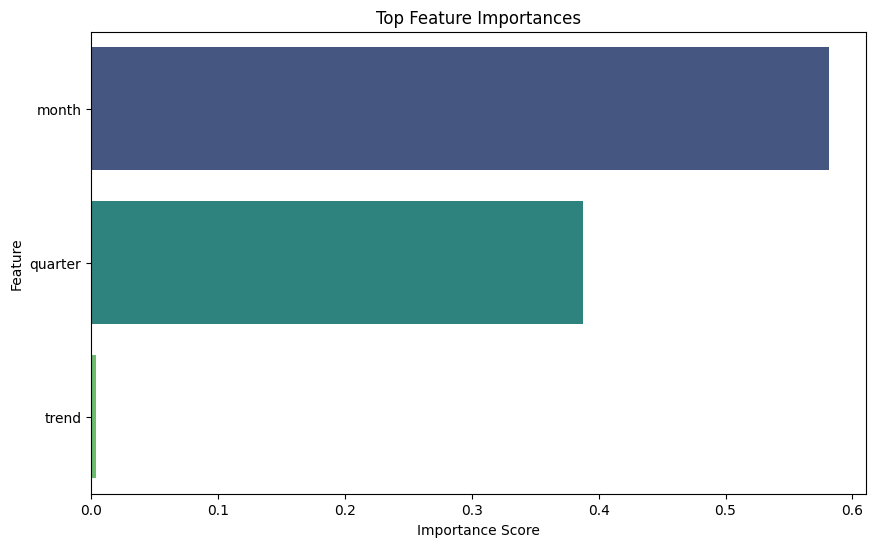

Random Forest - Validation MSE for dataset 227: 0.0036, RMSE: 0.0599
XGBoost - Validation MSE for dataset 227: 0.0036, RMSE: 0.0599
Models saved for dataset 227 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 227: 0.0036, RMSE: 0.0599
Top 3 features importance:
  Feature  Importance
0    lag5    0.097956
1    lag4    0.096374
2   trend    0.088160


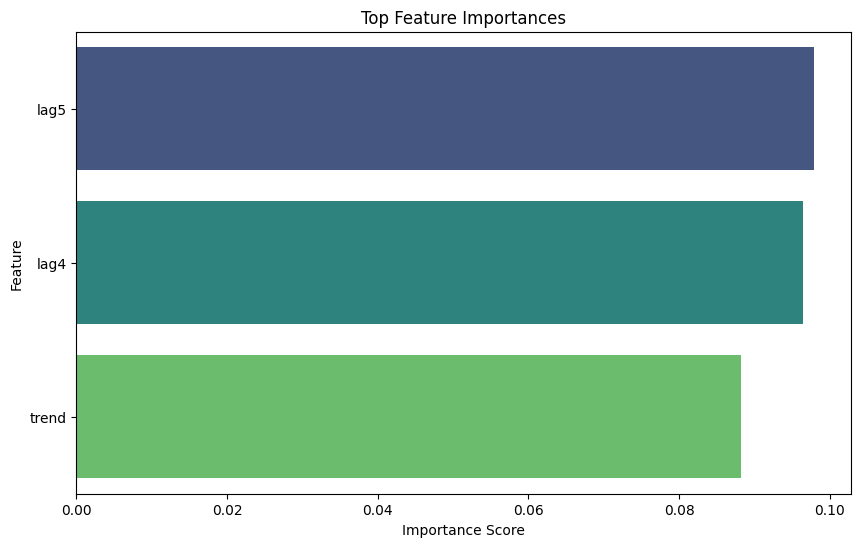

Random Forest - Validation MSE for dataset 242: 0.0196, RMSE: 0.1398
XGBoost - Validation MSE for dataset 242: 0.0189, RMSE: 0.1373
Models saved for dataset 242 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 242: 0.0182, RMSE: 0.1348
Top 3 features importance:
  Feature  Importance
0    lag1    0.924095
1    lag4    0.014071
2    lag3    0.011495


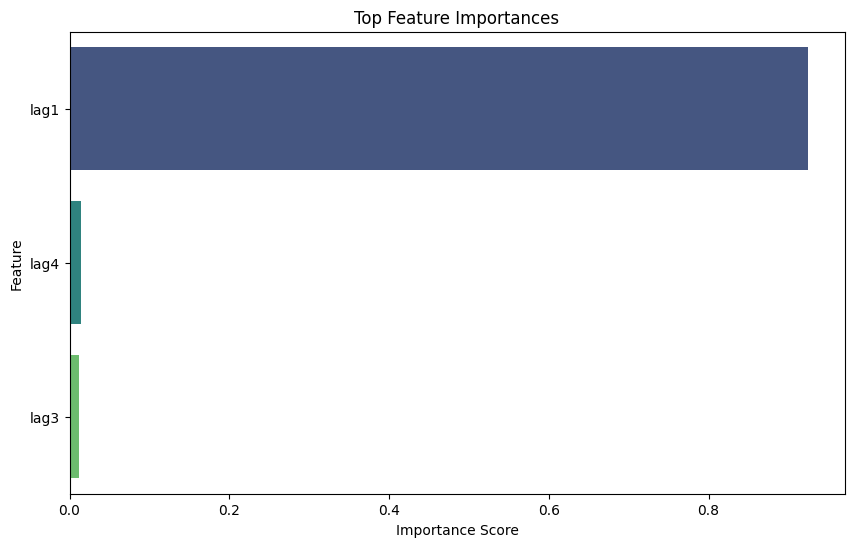

Random Forest - Validation MSE for dataset 246: 0.0041, RMSE: 0.0643
XGBoost - Validation MSE for dataset 246: 0.0038, RMSE: 0.0620
Models saved for dataset 246 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 246: 0.0032, RMSE: 0.0565
Top 3 features importance:
         Feature  Importance
0           lag1    0.955713
1  rolling_min_7    0.008758
2  rolling_std_3    0.005949


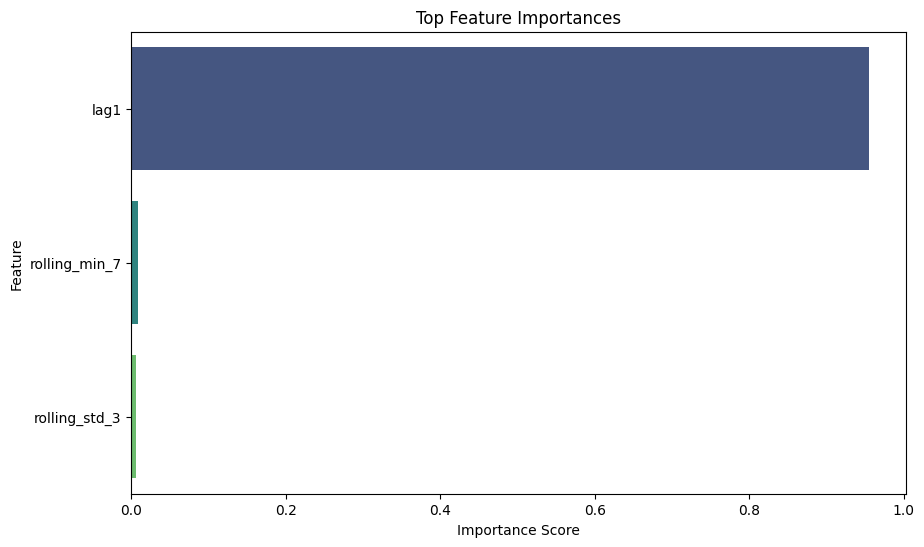

Random Forest - Validation MSE for dataset 251: 0.0007, RMSE: 0.0266
XGBoost - Validation MSE for dataset 251: 0.0005, RMSE: 0.0225
Models saved for dataset 251 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 251: 0.0005, RMSE: 0.0224
Top 3 features importance:
   Feature  Importance
0    month    0.561733
1  quarter    0.387157
2     lag1    0.021681


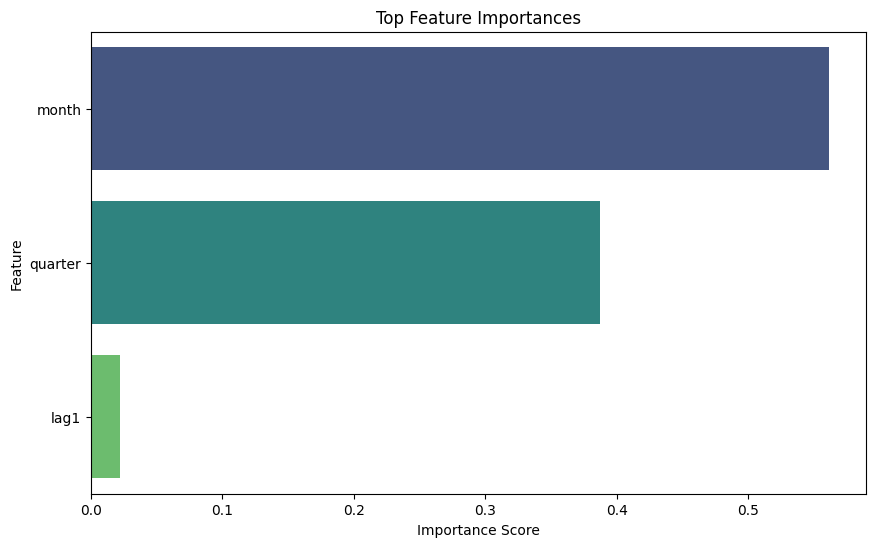

Random Forest - Validation MSE for dataset 256: 0.0068, RMSE: 0.0826
XGBoost - Validation MSE for dataset 256: 0.0066, RMSE: 0.0814
Models saved for dataset 256 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 256: 0.0066, RMSE: 0.0811
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.572853
1            lag1    0.173533
2            hour    0.063462


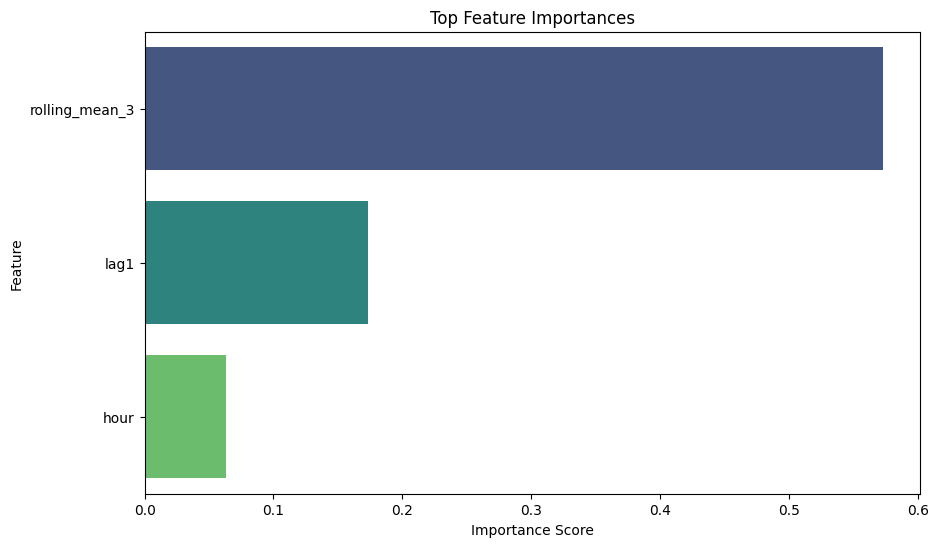

Random Forest - Validation MSE for dataset 272: 0.0380, RMSE: 0.1949
XGBoost - Validation MSE for dataset 272: 0.0444, RMSE: 0.2107
Models saved for dataset 272 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 272: 0.0401, RMSE: 0.2003
Top 3 features importance:
            Feature  Importance
0    rolling_mean_3    0.502618
1  rolling_median_7    0.174336
2              lag1    0.135344


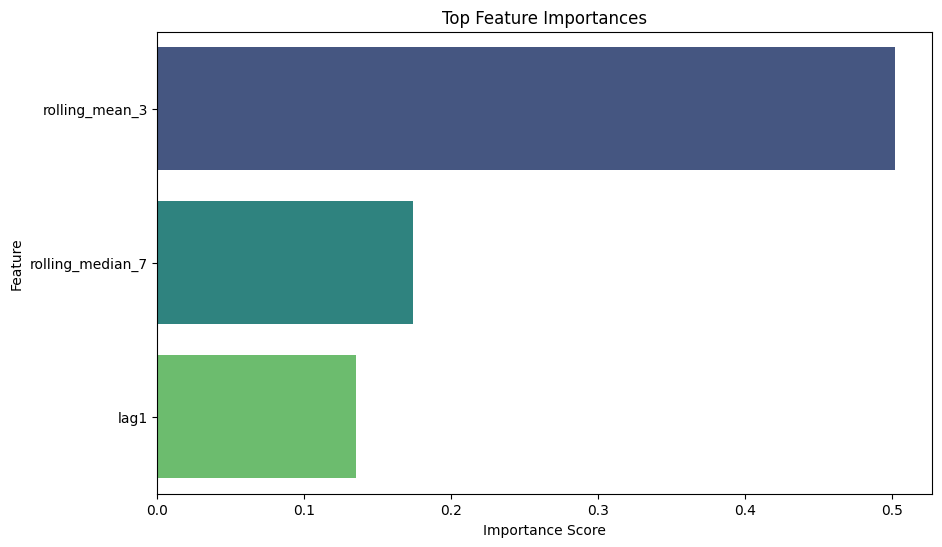

Random Forest - Validation MSE for dataset 287: 0.0309, RMSE: 0.1757
XGBoost - Validation MSE for dataset 287: 0.0428, RMSE: 0.2068
Models saved for dataset 287 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 287: 0.0363, RMSE: 0.1904
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.587506
1            lag1    0.168552
2            hour    0.048151


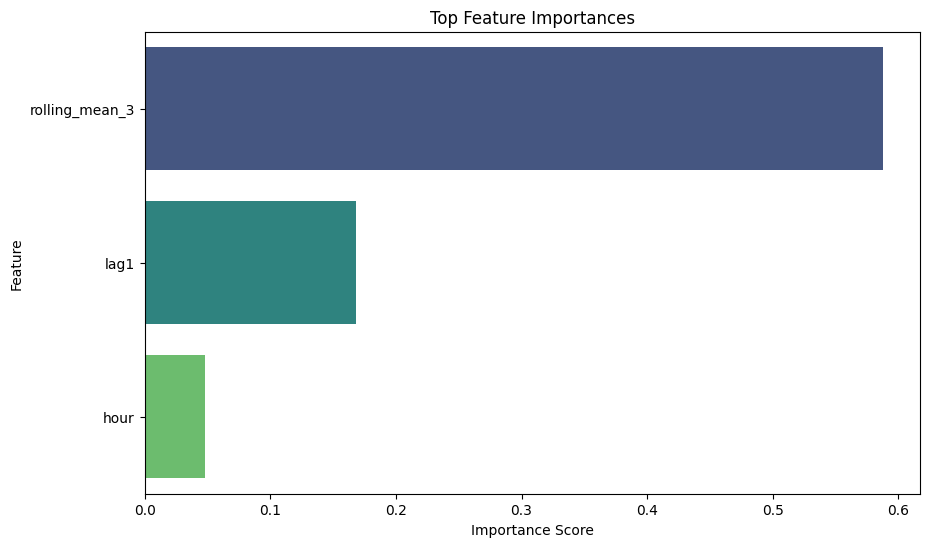

Random Forest - Validation MSE for dataset 290: 0.0462, RMSE: 0.2150
XGBoost - Validation MSE for dataset 290: 0.0503, RMSE: 0.2243
Models saved for dataset 290 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 290: 0.0475, RMSE: 0.2178
Top 3 features importance:
          Feature  Importance
0            lag1    0.468816
1  rolling_mean_3    0.242739
2            hour    0.056193


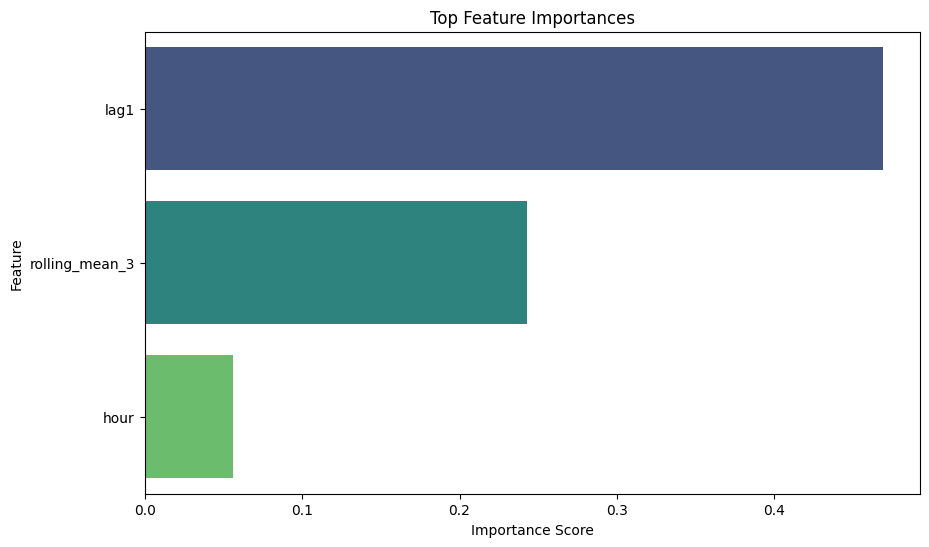

Random Forest - Validation MSE for dataset 294: 0.0253, RMSE: 0.1591
XGBoost - Validation MSE for dataset 294: 0.0347, RMSE: 0.1864
Models saved for dataset 294 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 294: 0.0279, RMSE: 0.1672
Top 3 features importance:
         Feature  Importance
0           lag1    0.998811
1  rolling_max_7    0.000239
2  rolling_min_7    0.000212


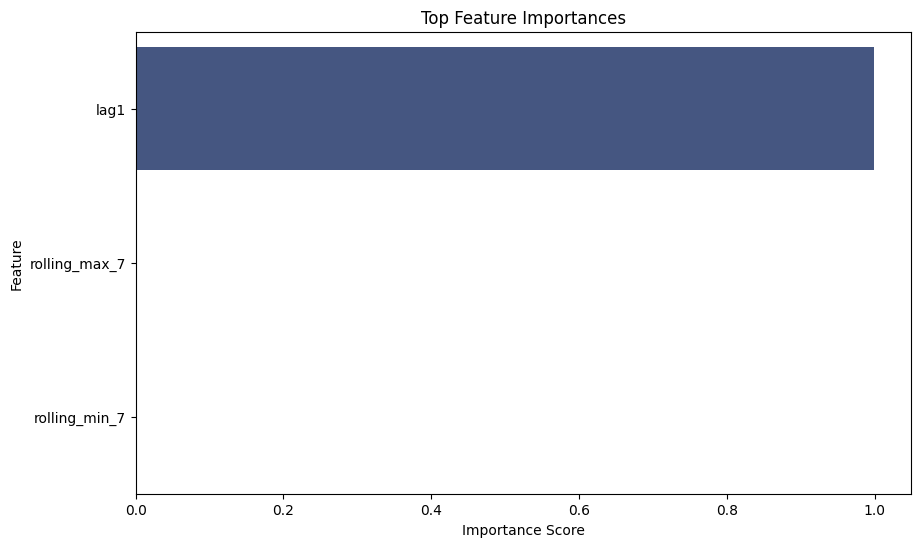

Random Forest - Validation MSE for dataset 297: 0.0001, RMSE: 0.0106
XGBoost - Validation MSE for dataset 297: 0.0001, RMSE: 0.0088
Models saved for dataset 297 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 297: 0.0001, RMSE: 0.0088
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.437554
1            lag1    0.183842
2            lag2    0.090676


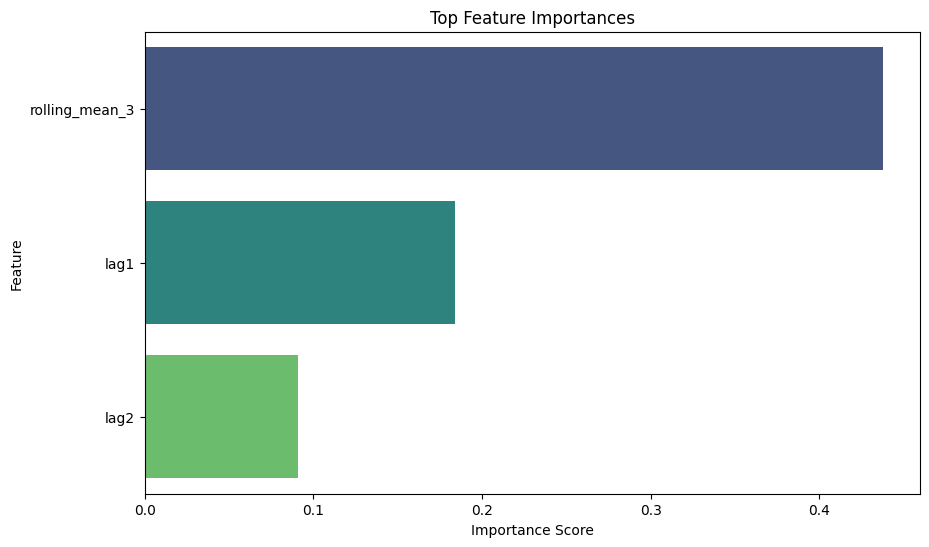

Random Forest - Validation MSE for dataset 300: 0.0583, RMSE: 0.2414
XGBoost - Validation MSE for dataset 300: 0.0650, RMSE: 0.2550
Models saved for dataset 300 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 300: 0.0604, RMSE: 0.2458
Top 3 features importance:
          Feature  Importance
0            lag1    0.996368
1            lag2    0.001124
2  rolling_mean_3    0.000828


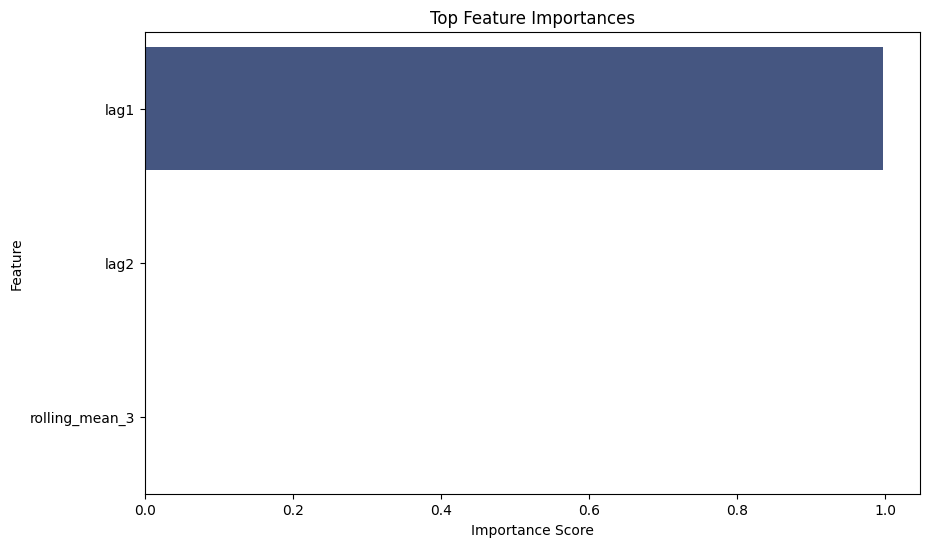

Random Forest - Validation MSE for dataset 301: 0.0002, RMSE: 0.0134
XGBoost - Validation MSE for dataset 301: 0.0002, RMSE: 0.0148
Models saved for dataset 301 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 301: 0.0001, RMSE: 0.0107
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.628031
1            lag1    0.176503
2            lag2    0.031223


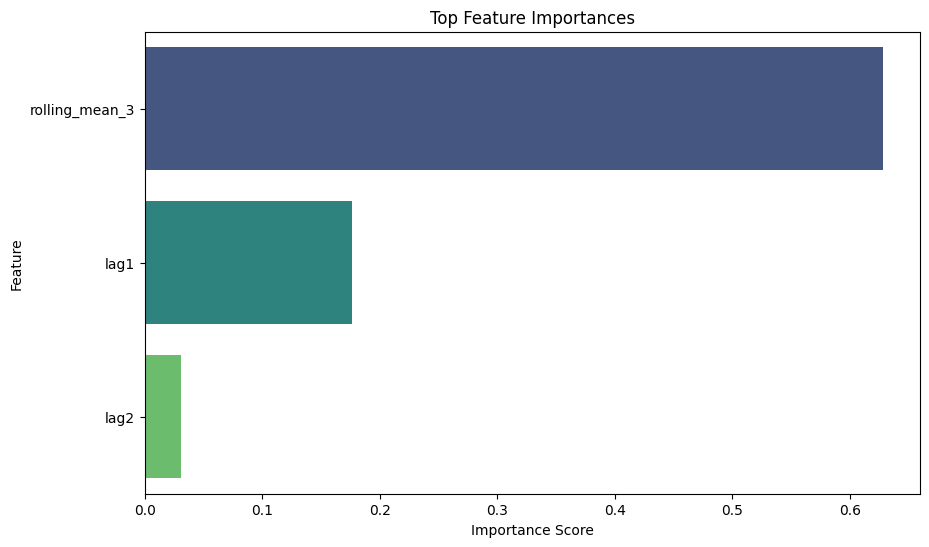

Random Forest - Validation MSE for dataset 306: 0.0219, RMSE: 0.1480
XGBoost - Validation MSE for dataset 306: 0.0324, RMSE: 0.1801
Models saved for dataset 306 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 306: 0.0262, RMSE: 0.1619
Top 3 features importance:
         Feature  Importance
0           lag1    0.982476
1           lag3    0.003422
2  rolling_std_3    0.002847


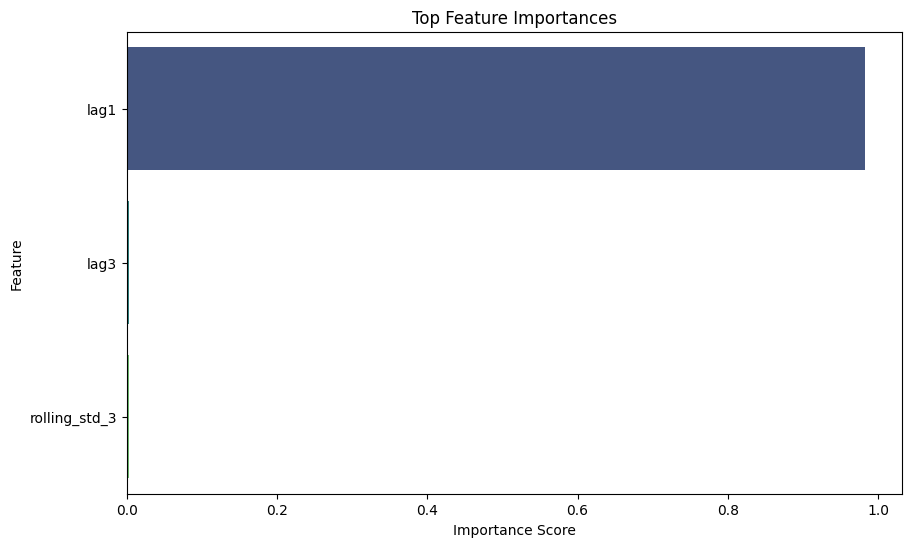

Random Forest - Validation MSE for dataset 310: 0.0052, RMSE: 0.0719
XGBoost - Validation MSE for dataset 310: 0.0017, RMSE: 0.0411
Models saved for dataset 310 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 310: 0.0029, RMSE: 0.0535
Top 3 features importance:
  Feature  Importance
0    lag1    0.964776
1    lag3    0.007385
2    hour    0.005192


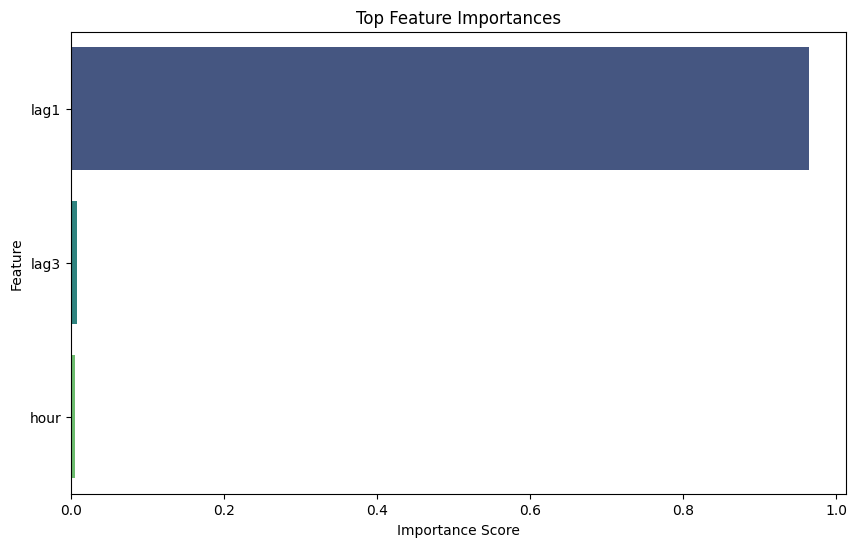

Random Forest - Validation MSE for dataset 314: 0.0045, RMSE: 0.0669
XGBoost - Validation MSE for dataset 314: 0.0025, RMSE: 0.0502
Models saved for dataset 314 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 314: 0.0030, RMSE: 0.0546
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.622397
1            lag1    0.163747
2            hour    0.047475


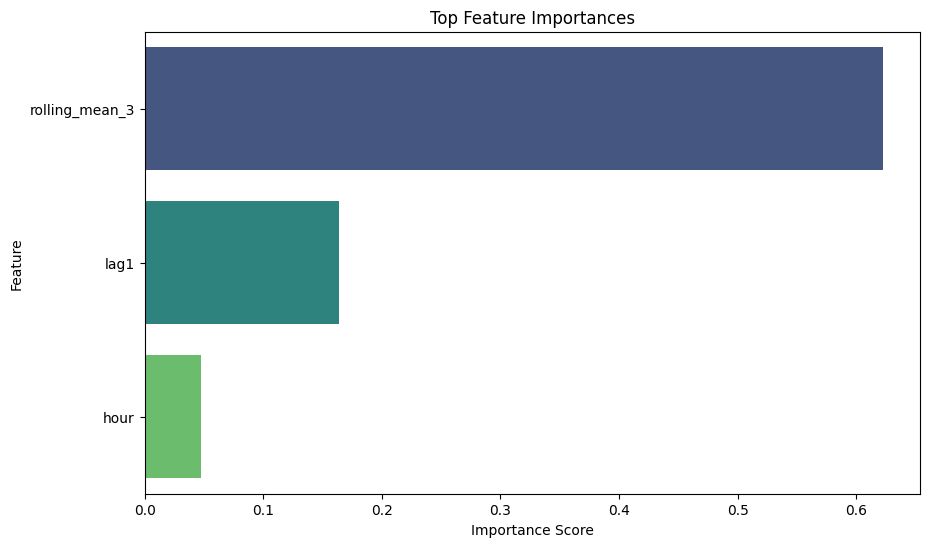

Random Forest - Validation MSE for dataset 321: 0.0488, RMSE: 0.2210
XGBoost - Validation MSE for dataset 321: 0.0523, RMSE: 0.2287
Models saved for dataset 321 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 321: 0.0495, RMSE: 0.2225
Top 3 features importance:
  Feature  Importance
0    lag1    0.400340
1    lag2    0.101849
2    hour    0.056505


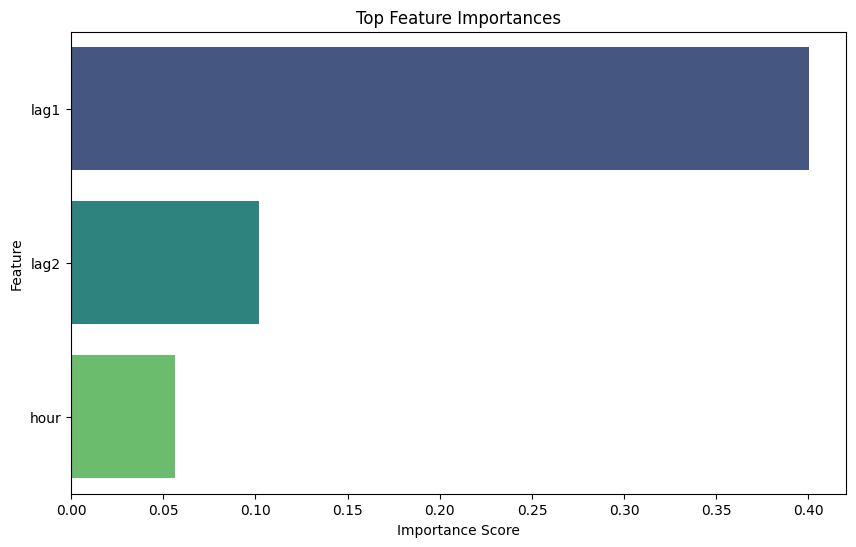

Random Forest - Validation MSE for dataset 325: 0.0638, RMSE: 0.2526
XGBoost - Validation MSE for dataset 325: 0.0677, RMSE: 0.2602
Models saved for dataset 325 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 325: 0.0644, RMSE: 0.2538
Top 3 features importance:
          Feature  Importance
0            lag1    0.793869
1            hour    0.048039
2  rolling_mean_3    0.035141


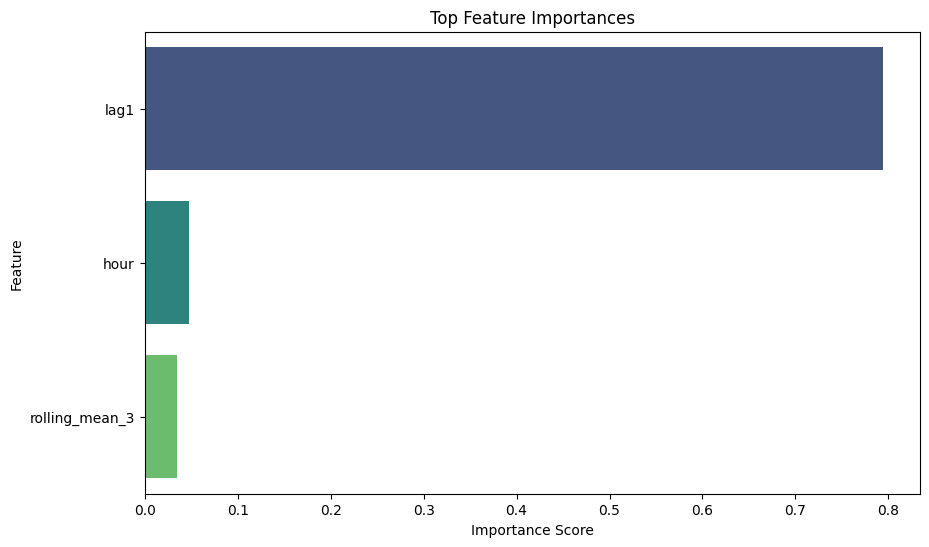

Random Forest - Validation MSE for dataset 335: 0.0386, RMSE: 0.1964
XGBoost - Validation MSE for dataset 335: 0.0425, RMSE: 0.2061
Models saved for dataset 335 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 335: 0.0395, RMSE: 0.1987
Top 3 features importance:
          Feature  Importance
0            lag1    0.690904
1  rolling_mean_3    0.091997
2            hour    0.041472


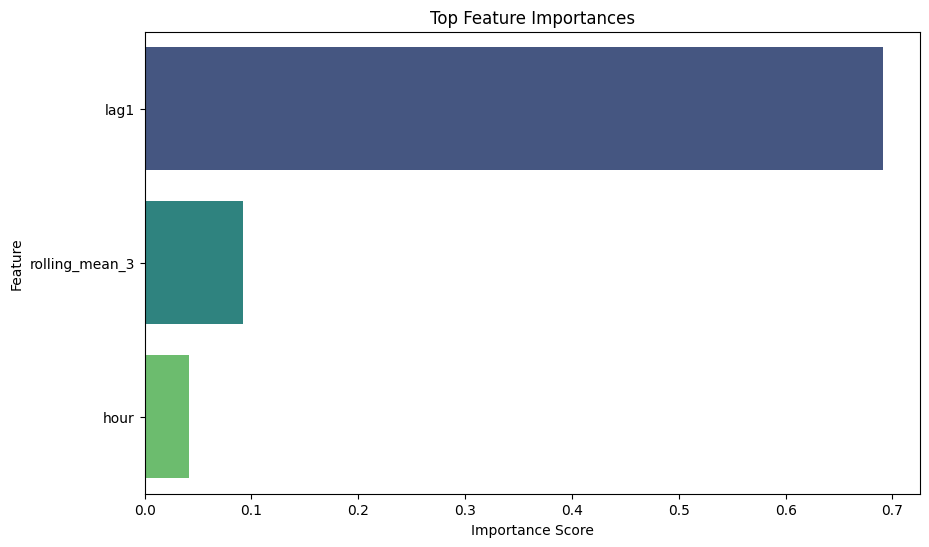

Random Forest - Validation MSE for dataset 338: 0.0492, RMSE: 0.2219
XGBoost - Validation MSE for dataset 338: 0.0528, RMSE: 0.2297
Models saved for dataset 338 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 338: 0.0497, RMSE: 0.2228
Top 3 features importance:
  Feature  Importance
0    lag1    0.966344
1    hour    0.009653
2    lag4    0.004106


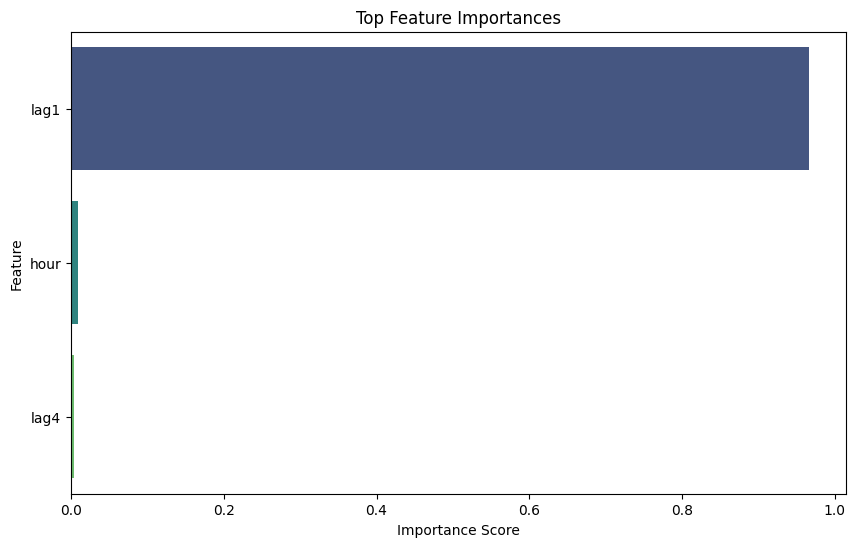

Random Forest - Validation MSE for dataset 348: 0.0007, RMSE: 0.0263
XGBoost - Validation MSE for dataset 348: 0.0004, RMSE: 0.0199
Models saved for dataset 348 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 348: 0.0004, RMSE: 0.0203
Top 3 features importance:
          Feature  Importance
0            lag1    0.806981
1            hour    0.036093
2  rolling_mean_3    0.029617


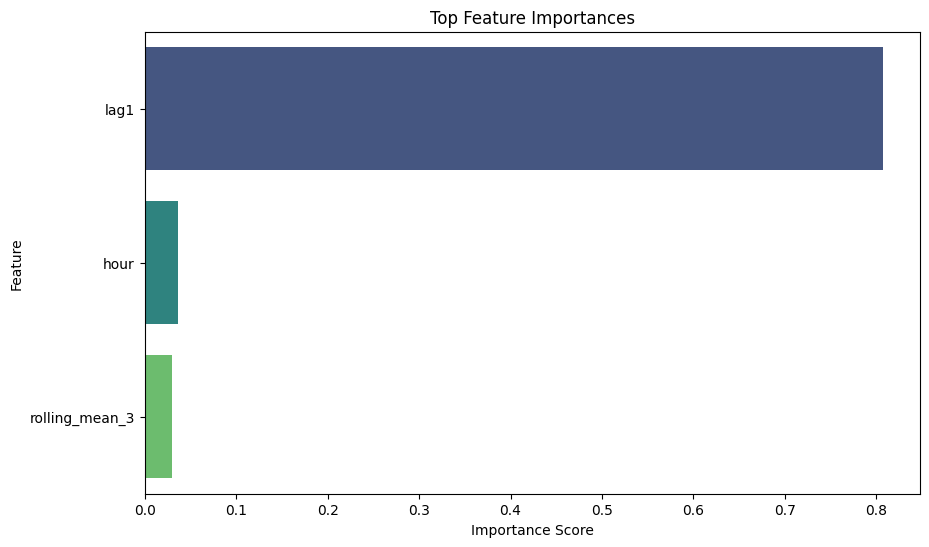

Random Forest - Validation MSE for dataset 352: 0.0161, RMSE: 0.1267
XGBoost - Validation MSE for dataset 352: 0.0162, RMSE: 0.1274
Models saved for dataset 352 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 352: 0.0158, RMSE: 0.1258
Top 3 features importance:
         Feature  Importance
0           lag1    0.970037
1  rolling_std_3    0.006315
2           lag5    0.004510


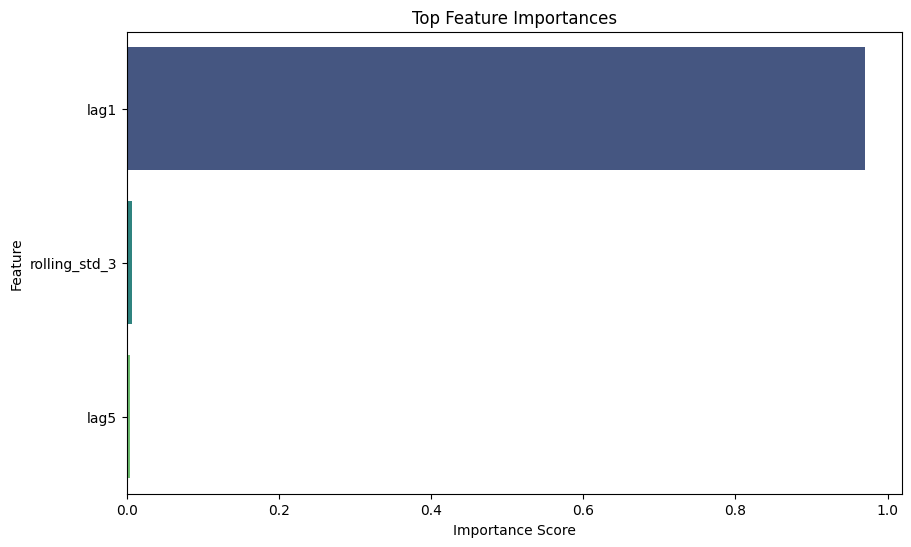

Random Forest - Validation MSE for dataset 354: 0.0012, RMSE: 0.0350
XGBoost - Validation MSE for dataset 354: 0.0009, RMSE: 0.0296
Models saved for dataset 354 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 354: 0.0009, RMSE: 0.0306
Top 3 features importance:
  Feature  Importance
0    lag1    0.427921
1    lag2    0.088660
2    hour    0.056204


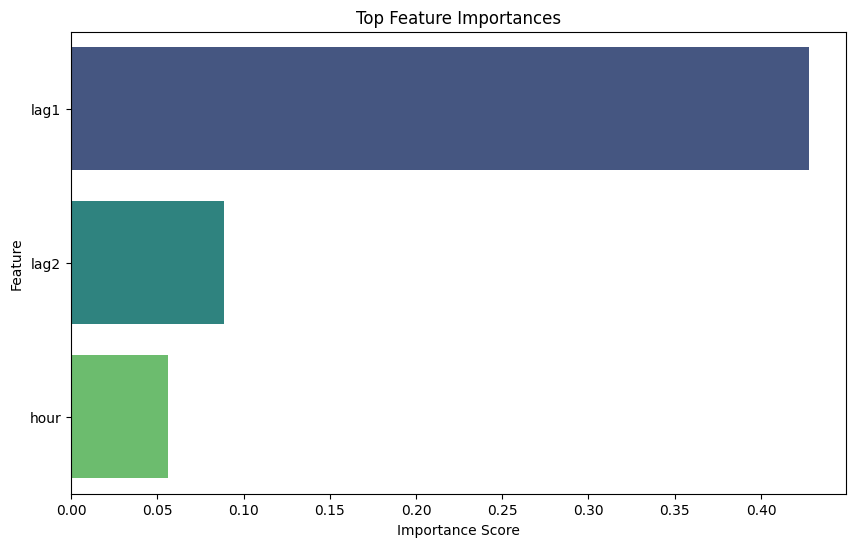

Random Forest - Validation MSE for dataset 361: 0.0497, RMSE: 0.2228
XGBoost - Validation MSE for dataset 361: 0.0539, RMSE: 0.2321
Models saved for dataset 361 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 361: 0.0505, RMSE: 0.2246
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.490292
1            lag1    0.303334
2            hour    0.043241


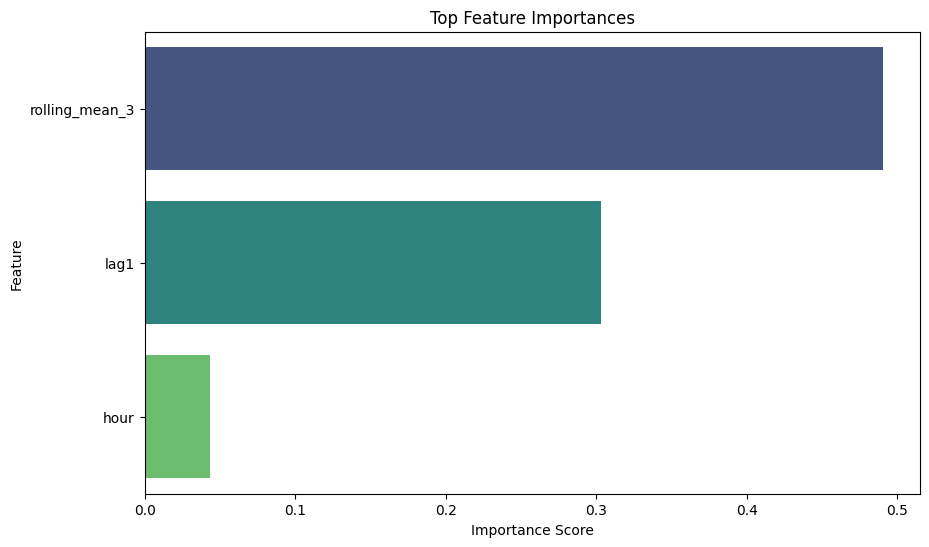

Random Forest - Validation MSE for dataset 367: 0.0390, RMSE: 0.1976
XGBoost - Validation MSE for dataset 367: 0.0426, RMSE: 0.2065
Models saved for dataset 367 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 367: 0.0399, RMSE: 0.1998
Top 3 features importance:
  Feature  Importance
0    lag1    0.970172
1    hour    0.007191
2    lag3    0.005712


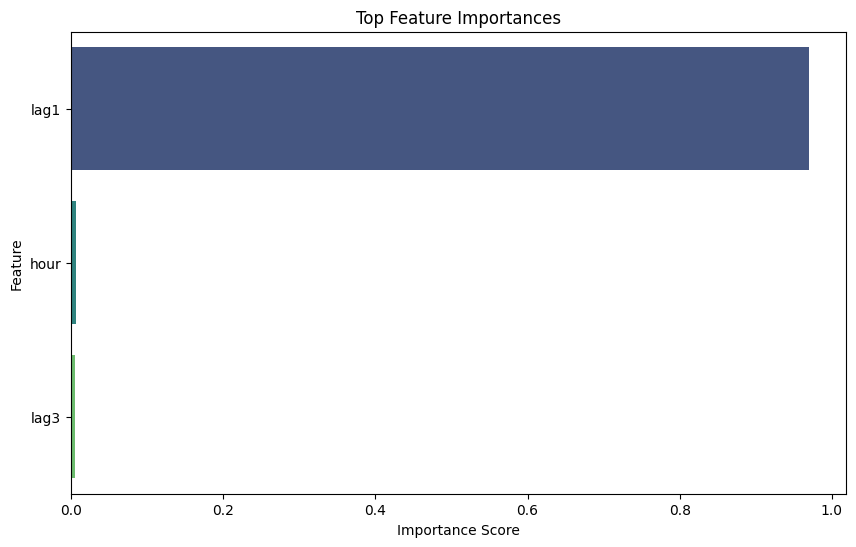

Random Forest - Validation MSE for dataset 370: 0.0033, RMSE: 0.0571
XGBoost - Validation MSE for dataset 370: 0.0016, RMSE: 0.0402
Models saved for dataset 370 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 370: 0.0018, RMSE: 0.0425
Top 3 features importance:
          Feature  Importance
0            lag1    0.790386
1  rolling_mean_3    0.063251
2            hour    0.034372


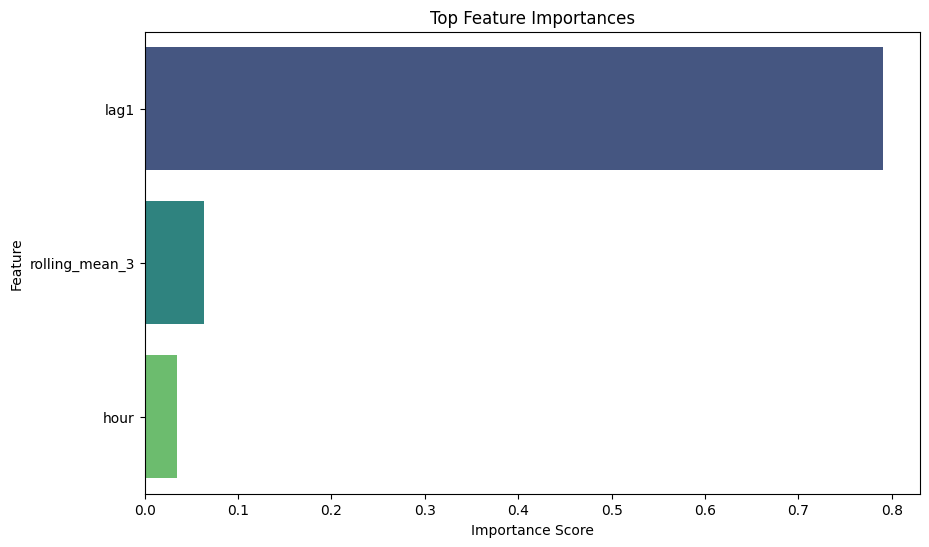

Random Forest - Validation MSE for dataset 383: 0.0381, RMSE: 0.1952
XGBoost - Validation MSE for dataset 383: 0.0379, RMSE: 0.1946
Models saved for dataset 383 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 383: 0.0366, RMSE: 0.1912
Top 3 features importance:
  Feature  Importance
0    lag1    0.900648
1    hour    0.040483
2   trend    0.010906


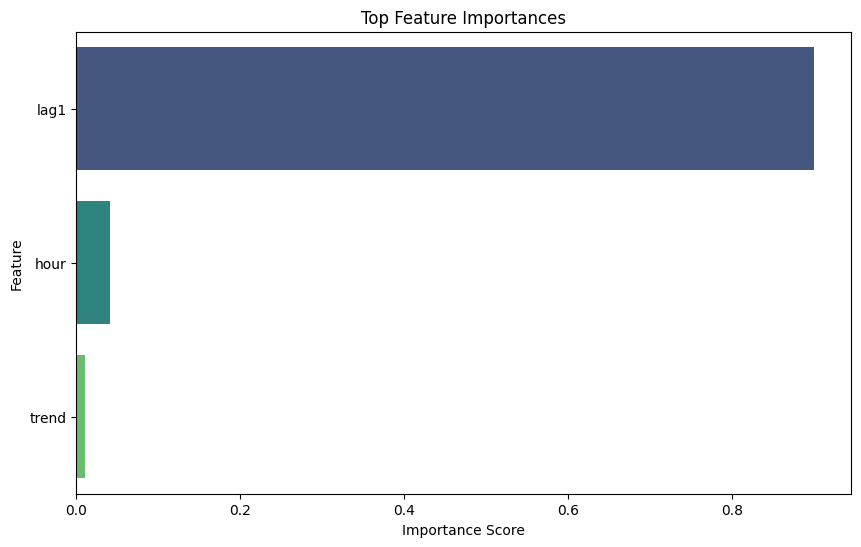

Random Forest - Validation MSE for dataset 386: 0.0624, RMSE: 0.2497
XGBoost - Validation MSE for dataset 386: 0.0778, RMSE: 0.2789
Models saved for dataset 386 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 386: 0.0675, RMSE: 0.2599
Top 3 features importance:
  Feature  Importance
0    lag1    0.840950
1    hour    0.098643
2   trend    0.014485


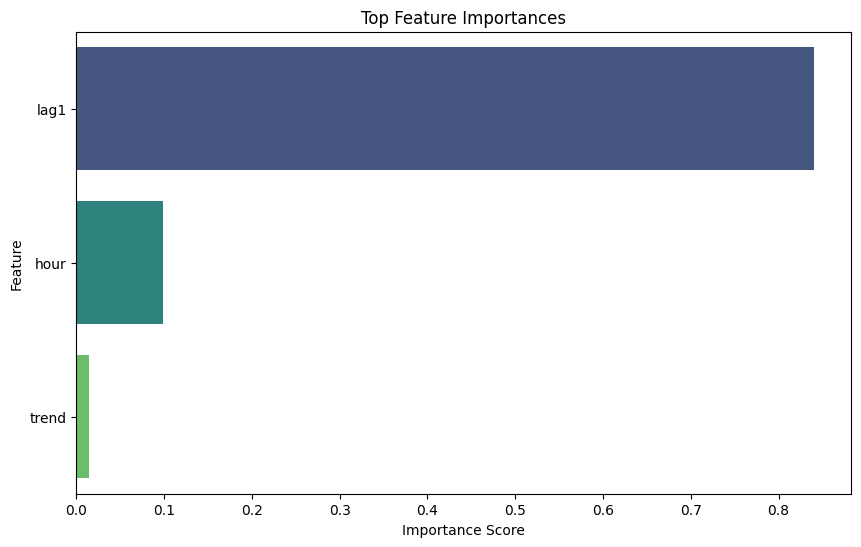

Random Forest - Validation MSE for dataset 391: 0.0099, RMSE: 0.0994
XGBoost - Validation MSE for dataset 391: 0.0098, RMSE: 0.0991
Models saved for dataset 391 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 391: 0.0094, RMSE: 0.0969
Top 3 features importance:
          Feature  Importance
0            lag1    0.998531
1  rolling_mean_3    0.000789
2            lag2    0.000297


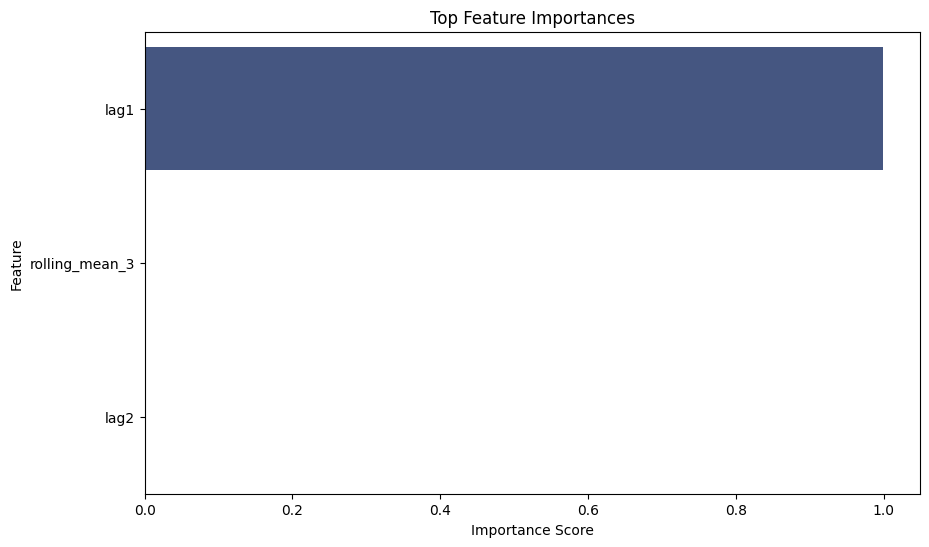

Random Forest - Validation MSE for dataset 397: 0.0002, RMSE: 0.0145
XGBoost - Validation MSE for dataset 397: 0.0005, RMSE: 0.0216
Models saved for dataset 397 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 397: 0.0002, RMSE: 0.0143
Top 3 features importance:
            Feature  Importance
0  rolling_median_7    0.486398
1              lag1    0.164289
2    rolling_mean_3    0.131457


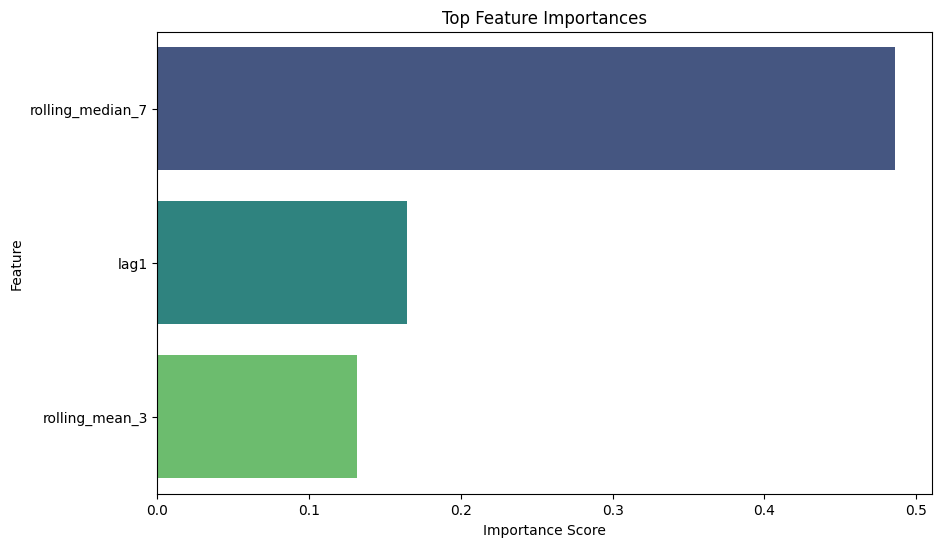

Random Forest - Validation MSE for dataset 401: 0.0477, RMSE: 0.2185
XGBoost - Validation MSE for dataset 401: 0.0680, RMSE: 0.2607
Models saved for dataset 401 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 401: 0.0566, RMSE: 0.2379
Top 3 features importance:
         Feature  Importance
0           lag1    0.998085
1           lag5    0.000275
2  rolling_min_7    0.000269


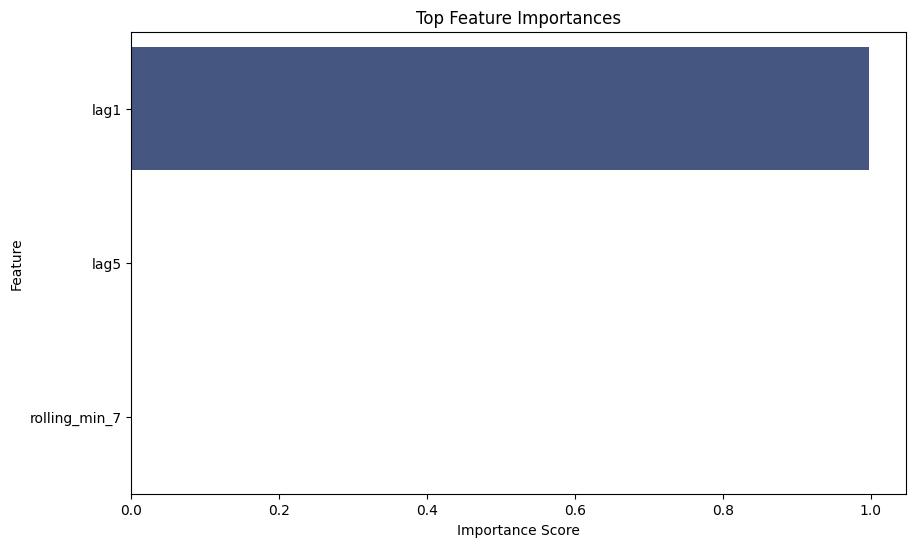

Random Forest - Validation MSE for dataset 421: 0.0008, RMSE: 0.0275
XGBoost - Validation MSE for dataset 421: 0.0012, RMSE: 0.0351
Models saved for dataset 421 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 421: 0.0002, RMSE: 0.0153
Top 3 features importance:
  Feature  Importance
0    lag1    0.734099
1    hour    0.098798
2   trend    0.037677


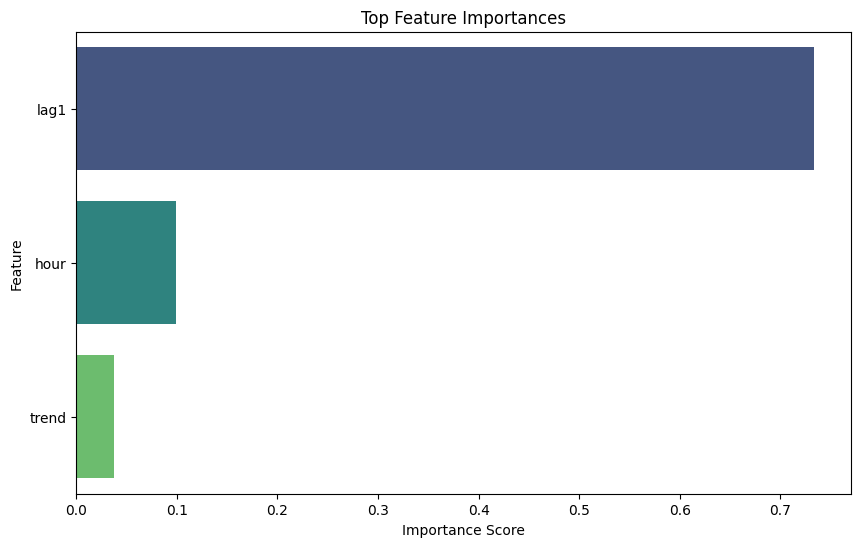

Random Forest - Validation MSE for dataset 428: 0.0684, RMSE: 0.2616
XGBoost - Validation MSE for dataset 428: 0.0811, RMSE: 0.2848
Models saved for dataset 428 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 428: 0.0711, RMSE: 0.2667
Top 3 features importance:
         Feature  Importance
0           lag1    0.998228
1           lag5    0.000242
2  rolling_min_7    0.000236


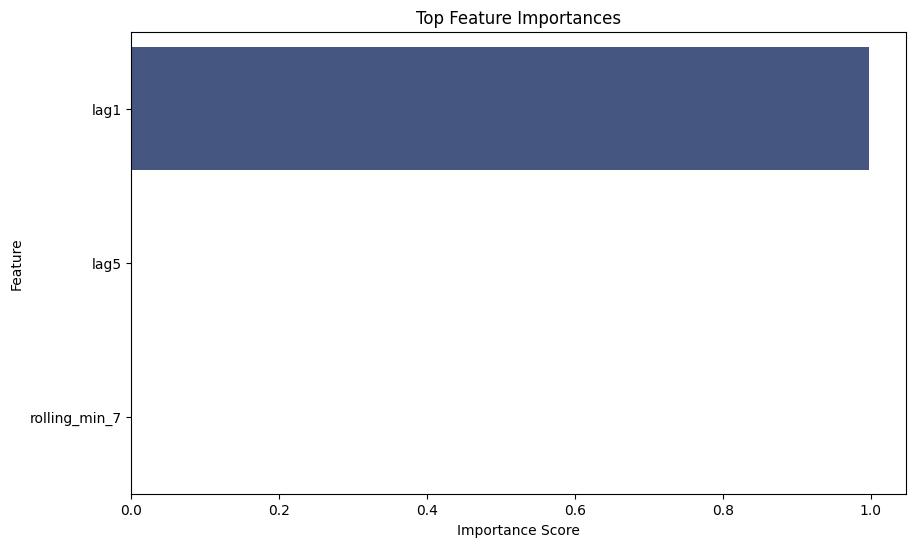

Random Forest - Validation MSE for dataset 429: 0.0003, RMSE: 0.0185
XGBoost - Validation MSE for dataset 429: 0.0015, RMSE: 0.0393
Models saved for dataset 429 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 429: 0.0006, RMSE: 0.0236
Top 3 features importance:
          Feature  Importance
0            lag1    0.961185
1  rolling_mean_3    0.024676
2   rolling_max_7    0.013427


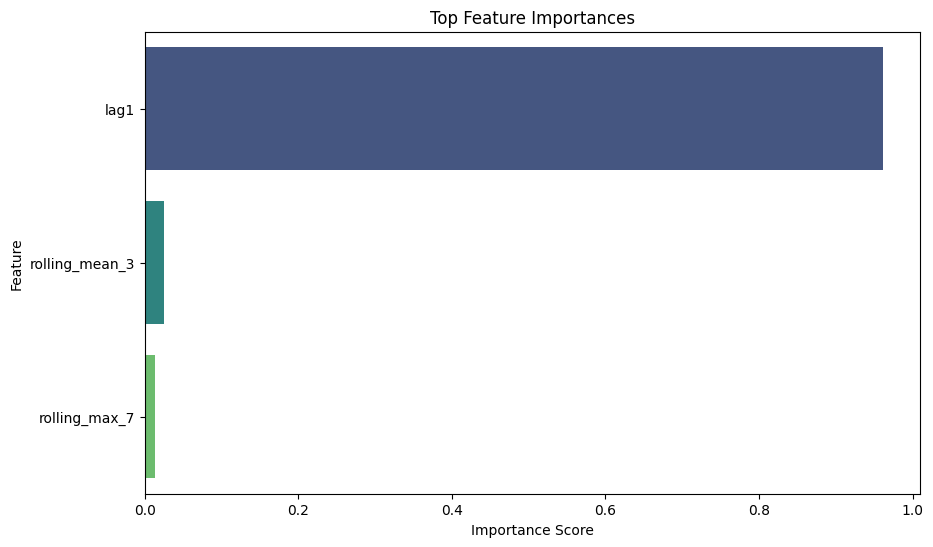

Random Forest - Validation MSE for dataset 430: 0.1210, RMSE: 0.3478
XGBoost - Validation MSE for dataset 430: 0.1257, RMSE: 0.3545
Models saved for dataset 430 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 430: 0.1230, RMSE: 0.3508
Top 3 features importance:
          Feature  Importance
0            lag1    0.798558
1  rolling_mean_3    0.078696
2            lag2    0.030203


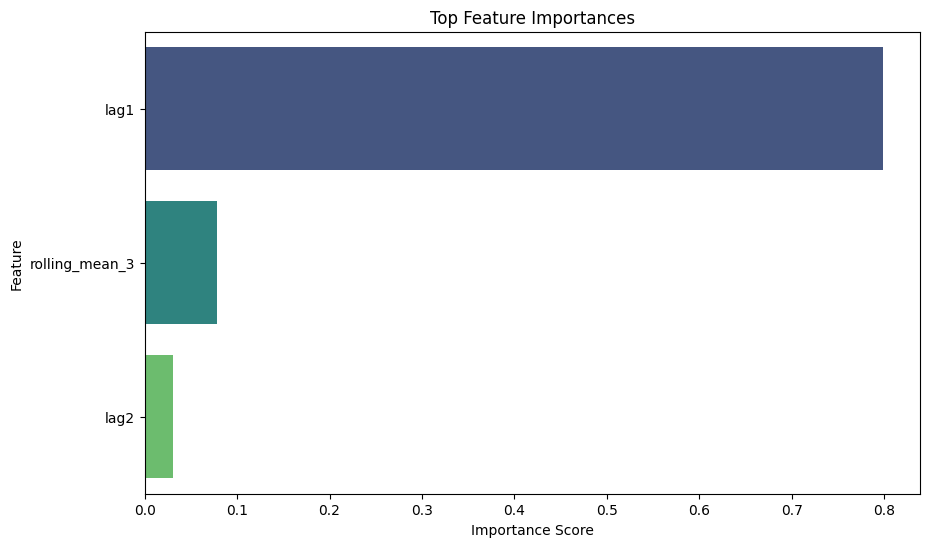

Random Forest - Validation MSE for dataset 435: 0.0109, RMSE: 0.1044
XGBoost - Validation MSE for dataset 435: 0.0108, RMSE: 0.1038
Models saved for dataset 435 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 435: 0.0107, RMSE: 0.1035
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.375918
1           trend    0.198256
2            lag1    0.129762


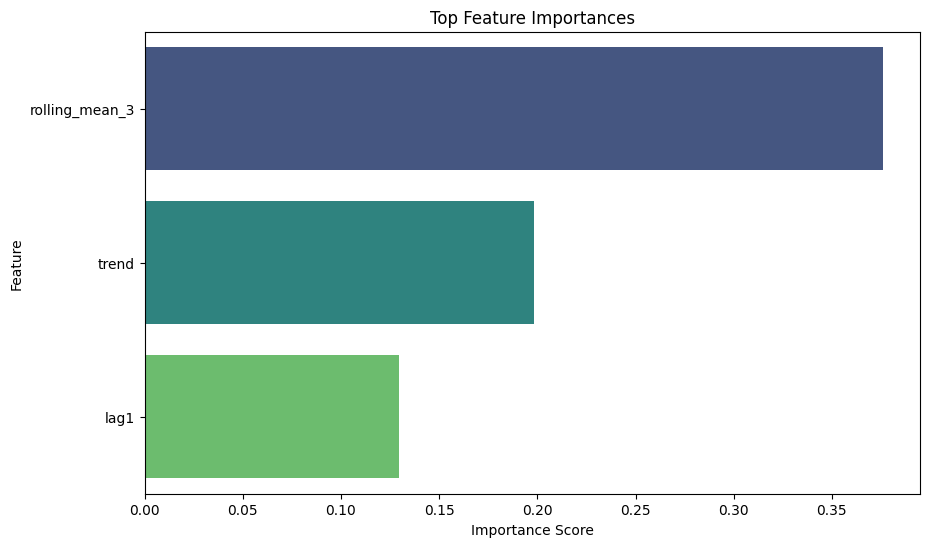

Random Forest - Validation MSE for dataset 437: 0.0468, RMSE: 0.2164
XGBoost - Validation MSE for dataset 437: 0.0415, RMSE: 0.2037
Models saved for dataset 437 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 437: 0.0438, RMSE: 0.2092
Top 3 features importance:
         Feature  Importance
0           lag1    0.999082
1          trend    0.000195
2  rolling_min_7    0.000102


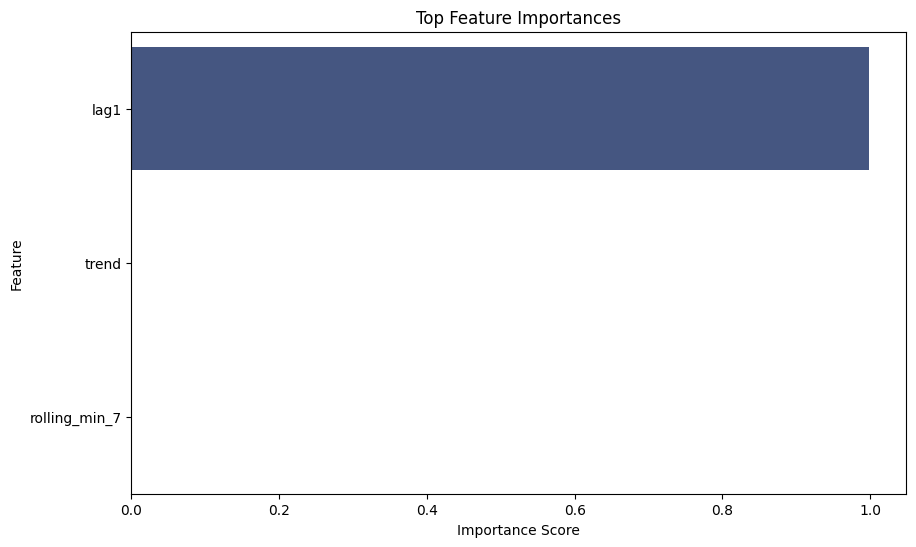

Random Forest - Validation MSE for dataset 439: 0.0021, RMSE: 0.0457
XGBoost - Validation MSE for dataset 439: 0.0015, RMSE: 0.0386
Models saved for dataset 439 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 439: 0.0017, RMSE: 0.0410
Top 3 features importance:
          Feature  Importance
0            lag1    0.592460
1  rolling_mean_3    0.206714
2           trend    0.046536


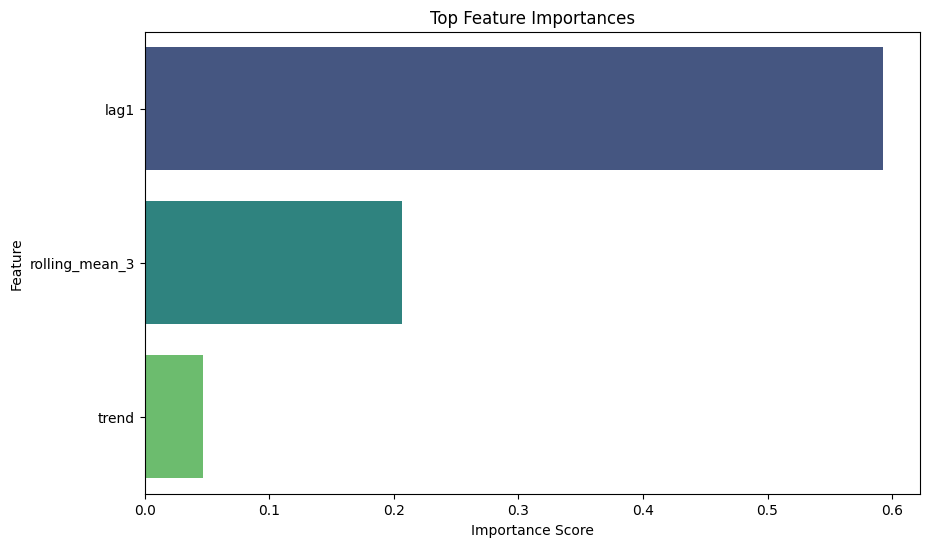

Random Forest - Validation MSE for dataset 440: 0.0173, RMSE: 0.1316
XGBoost - Validation MSE for dataset 440: 0.0155, RMSE: 0.1245
Models saved for dataset 440 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 440: 0.0161, RMSE: 0.1270
Top 3 features importance:
         Feature  Importance
0           lag1    0.956166
1           hour    0.011139
2  rolling_std_3    0.010181


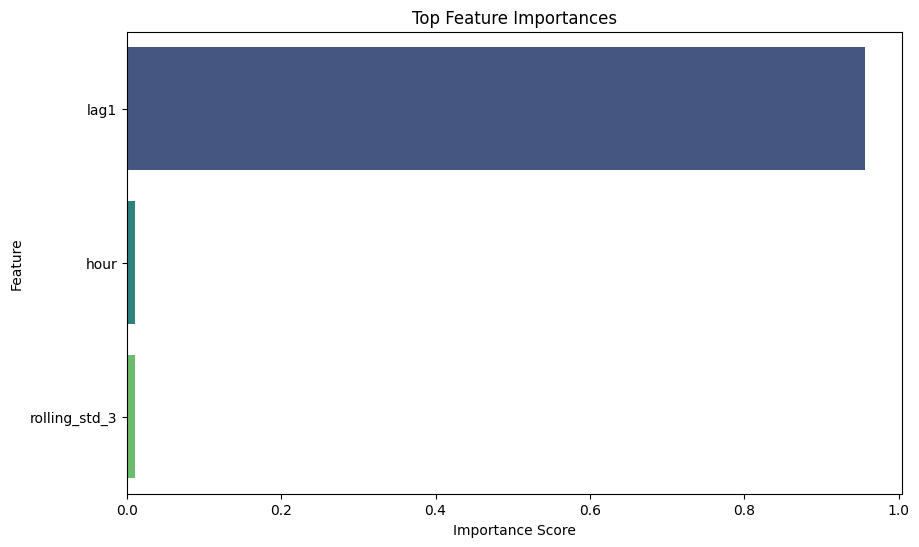

Random Forest - Validation MSE for dataset 446: 0.0345, RMSE: 0.1857
XGBoost - Validation MSE for dataset 446: 0.0113, RMSE: 0.1062
Models saved for dataset 446 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 446: 0.0188, RMSE: 0.1372
Top 3 features importance:
          Feature  Importance
0  rolling_mean_3    0.616902
1            lag1    0.180095
2            lag2    0.037566


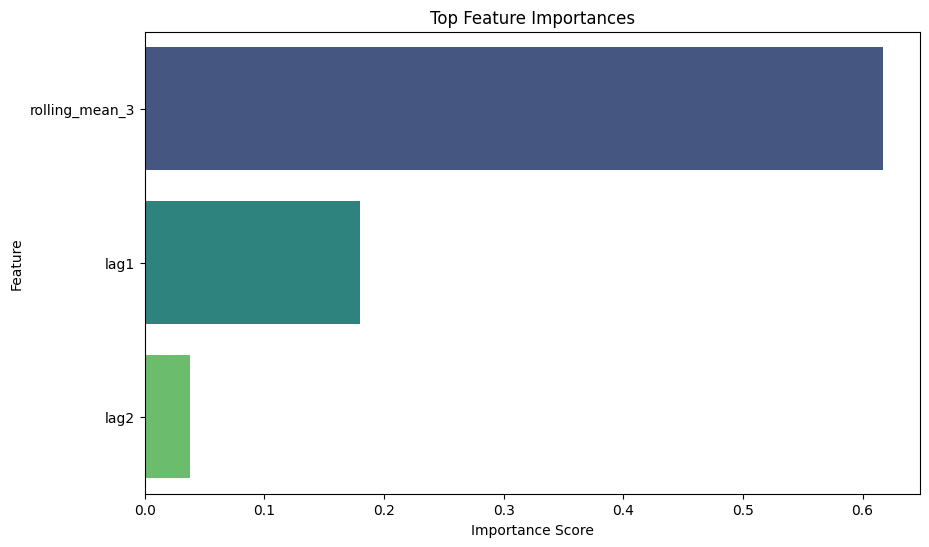

Random Forest - Validation MSE for dataset 447: 0.0432, RMSE: 0.2079
XGBoost - Validation MSE for dataset 447: 0.0724, RMSE: 0.2690
Models saved for dataset 447 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 447: 0.0556, RMSE: 0.2358
Top 3 features importance:
         Feature  Importance
0           lag1    0.969779
1           hour    0.013780
2  rolling_max_7    0.003660


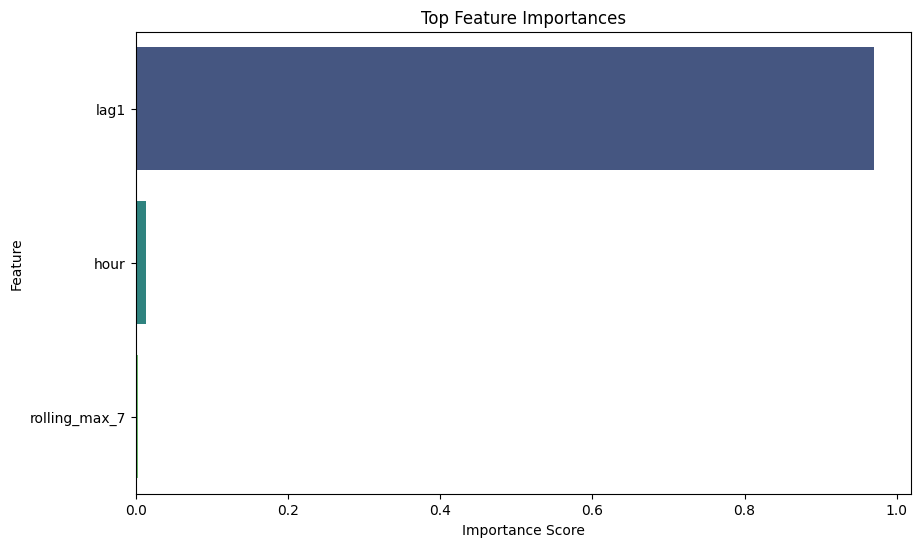

Random Forest - Validation MSE for dataset 451: 0.0013, RMSE: 0.0358
XGBoost - Validation MSE for dataset 451: 0.0007, RMSE: 0.0270
Models saved for dataset 451 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 451: 0.0009, RMSE: 0.0292
Top 3 features importance:
          Feature  Importance
0            lag1    0.829008
1            hour    0.115982
2  rolling_mean_3    0.017848


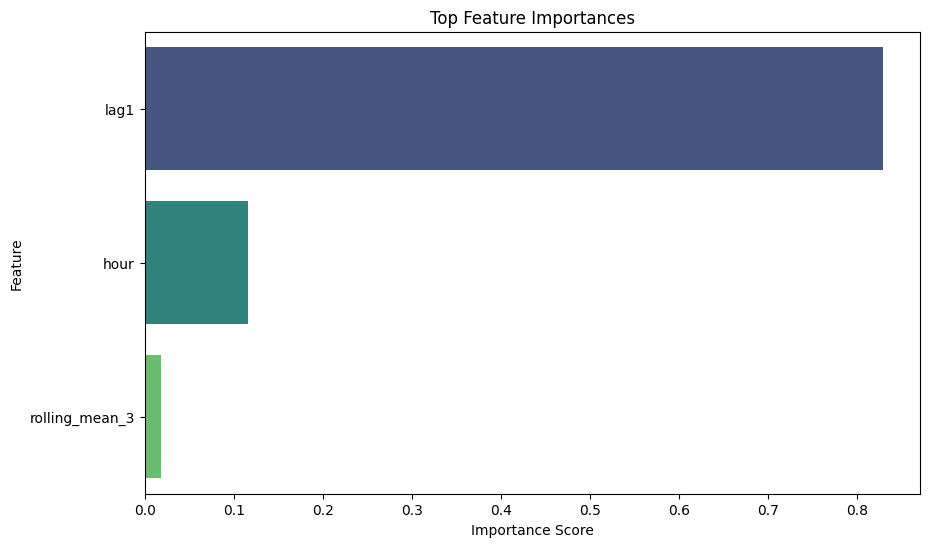

Random Forest - Validation MSE for dataset 453: 0.1965, RMSE: 0.4433
XGBoost - Validation MSE for dataset 453: 0.7033, RMSE: 0.8386
Models saved for dataset 453 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 453: 0.4075, RMSE: 0.6384
Top 3 features importance:
  Feature  Importance
0    lag1    0.956777
1    lag3    0.012136
2    lag4    0.006000


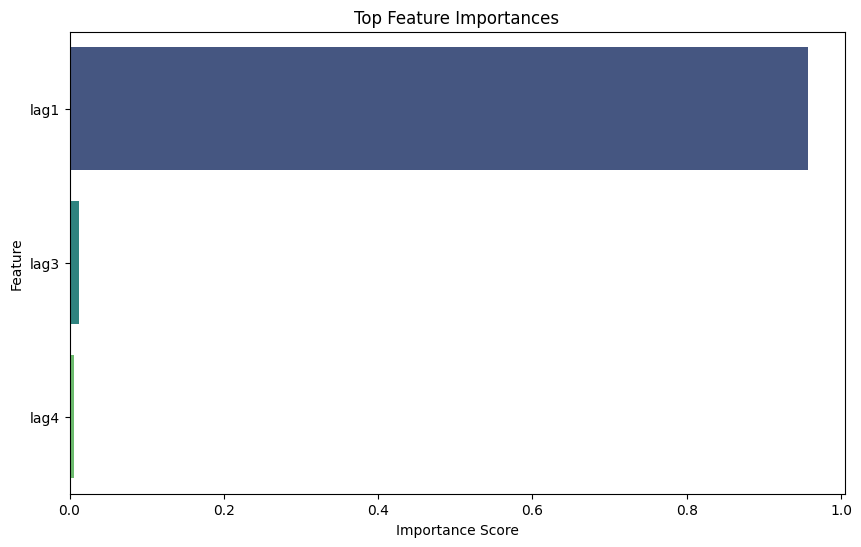

Random Forest - Validation MSE for dataset 461: 0.0012, RMSE: 0.0342
XGBoost - Validation MSE for dataset 461: 0.0010, RMSE: 0.0322
Models saved for dataset 461 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 461: 0.0010, RMSE: 0.0320
Top 3 features importance:
  Feature  Importance
0    lag1    0.959642
1    lag3    0.008650
2    lag4    0.008535


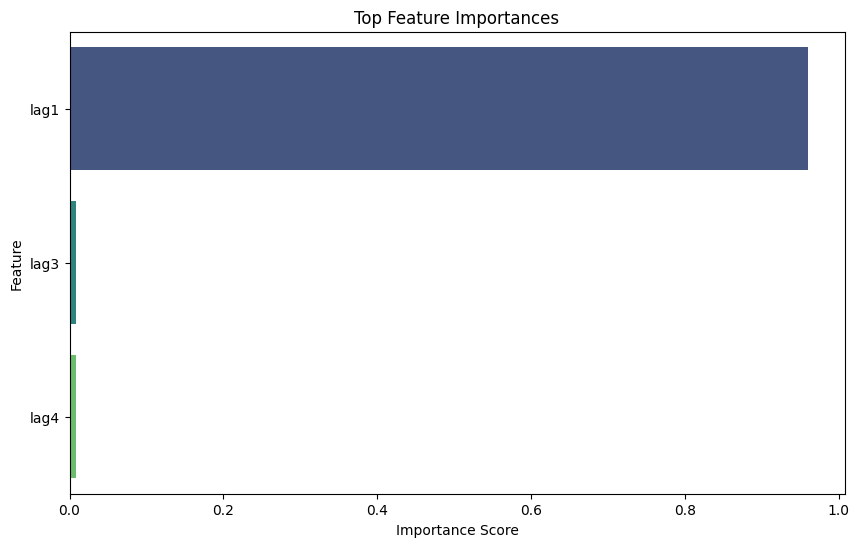

Random Forest - Validation MSE for dataset 462: 0.0022, RMSE: 0.0474
XGBoost - Validation MSE for dataset 462: 0.0019, RMSE: 0.0440
Models saved for dataset 462 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 462: 0.0019, RMSE: 0.0431
Top 3 features importance:
  Feature  Importance
0    hour    0.805350
1    lag1    0.096243
2    lag2    0.014655


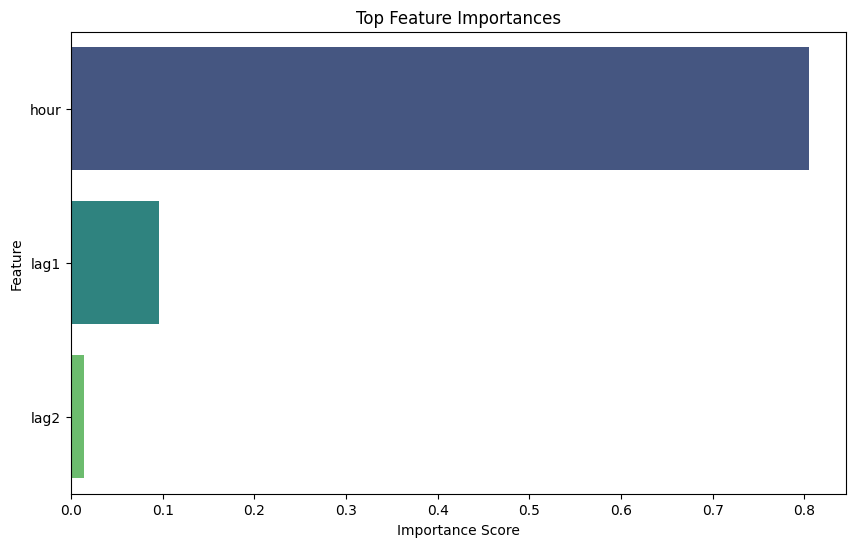

Random Forest - Validation MSE for dataset 465: 0.0253, RMSE: 0.1592
XGBoost - Validation MSE for dataset 465: 0.0278, RMSE: 0.1668
Models saved for dataset 465 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 465: 0.0257, RMSE: 0.1604
Top 3 features importance:
         Feature  Importance
0           lag1    0.999500
1  rolling_min_7    0.000077
2          trend    0.000072


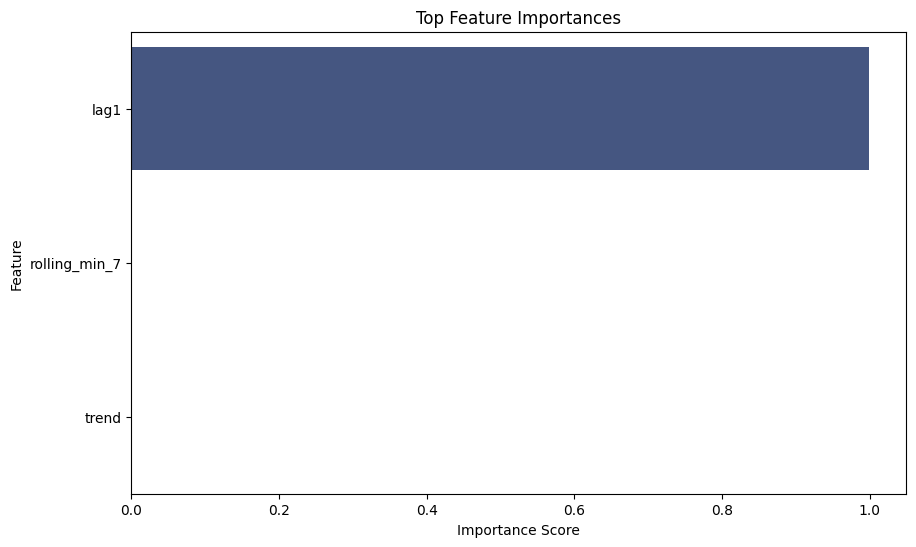

Random Forest - Validation MSE for dataset 469: 0.0155, RMSE: 0.1245
XGBoost - Validation MSE for dataset 469: 0.0039, RMSE: 0.0626
Models saved for dataset 469 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 469: 0.0083, RMSE: 0.0909
Top 3 features importance:
         Feature  Importance
0           lag1    0.991396
1          trend    0.004697
2  rolling_min_7    0.001794


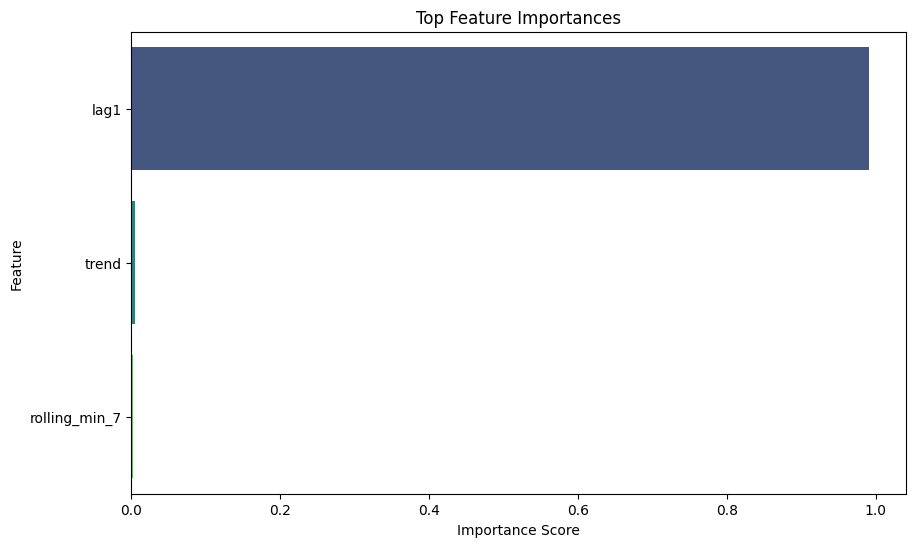

Random Forest - Validation MSE for dataset 482: 0.0025, RMSE: 0.0498
XGBoost - Validation MSE for dataset 482: 0.0010, RMSE: 0.0320
Models saved for dataset 482 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 482: 0.0016, RMSE: 0.0399
Top 3 features importance:
  Feature  Importance
0    lag1    0.656177
1    hour    0.130706
2   month    0.025397


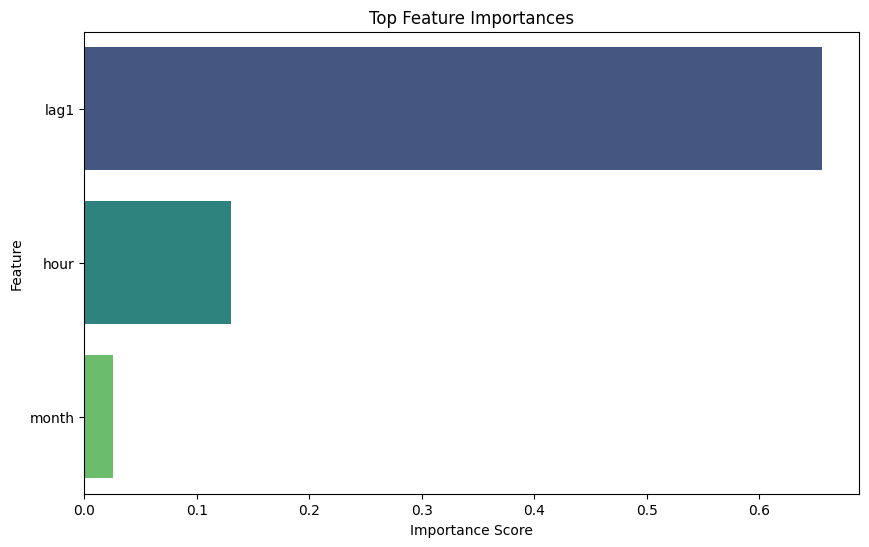

Random Forest - Validation MSE for dataset 483: 0.0186, RMSE: 0.1365
XGBoost - Validation MSE for dataset 483: 0.0182, RMSE: 0.1351
Models saved for dataset 483 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 483: 0.0178, RMSE: 0.1333
Top 3 features importance:
         Feature  Importance
0          trend    0.491331
1  rolling_min_7    0.137706
2           lag1    0.134941


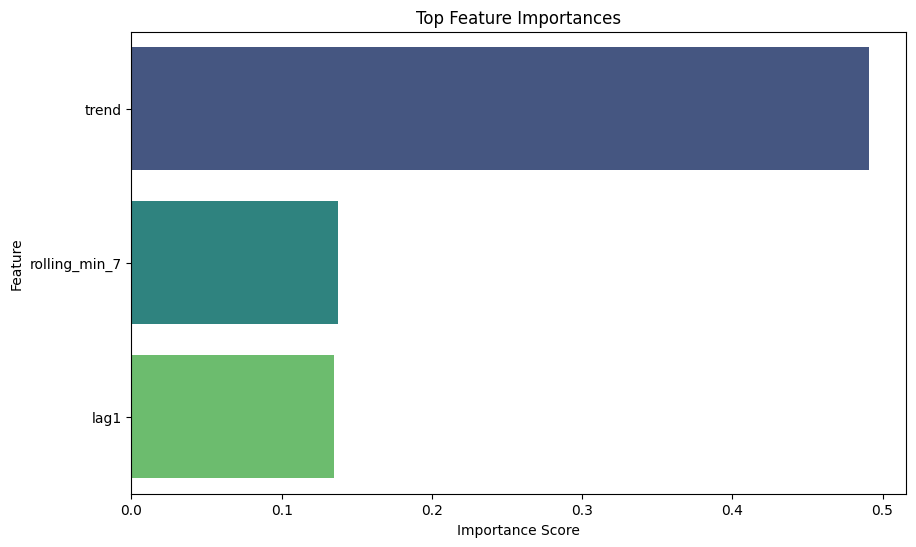

Random Forest - Validation MSE for dataset 490: 0.0016, RMSE: 0.0395
XGBoost - Validation MSE for dataset 490: 0.0004, RMSE: 0.0200
Models saved for dataset 490 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 490: 0.0008, RMSE: 0.0290
Top 3 features importance:
         Feature  Importance
0           lag1    0.999711
1  rolling_min_7    0.000050
2  rolling_max_7    0.000042


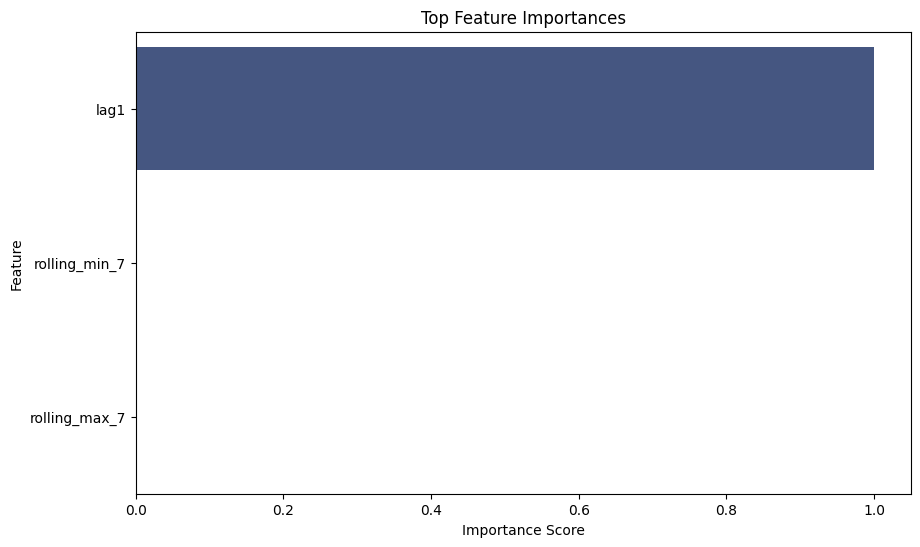

Random Forest - Validation MSE for dataset 491: 0.0005, RMSE: 0.0228
XGBoost - Validation MSE for dataset 491: 0.0002, RMSE: 0.0151
Models saved for dataset 491 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 491: 0.0003, RMSE: 0.0166
Top 3 features importance:
          Feature  Importance
0            lag1    0.794869
1            hour    0.104656
2  rolling_mean_3    0.017015


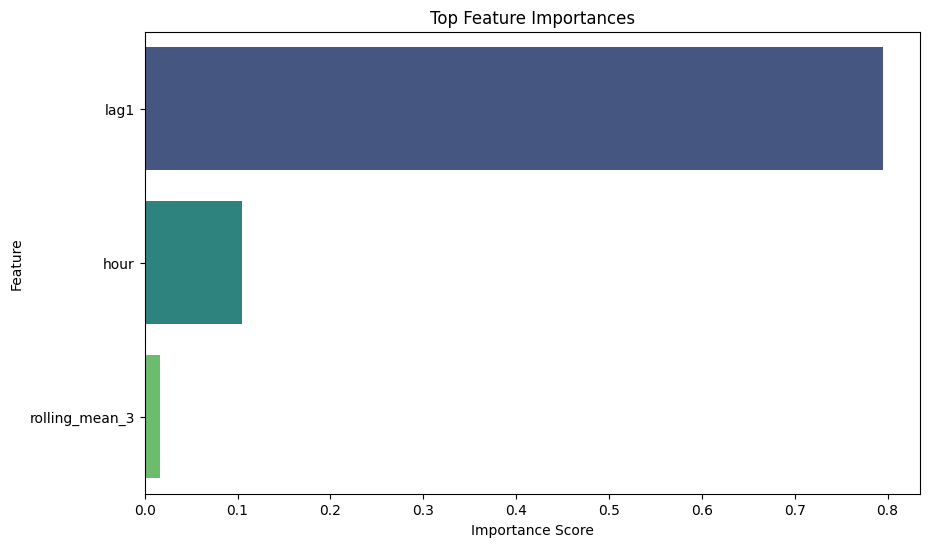

Random Forest - Validation MSE for dataset 495: 0.0392, RMSE: 0.1980
XGBoost - Validation MSE for dataset 495: 0.0451, RMSE: 0.2124
Models saved for dataset 495 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 495: 0.0409, RMSE: 0.2023
Top 3 features importance:
  Feature  Importance
0    lag1    0.811433
1    hour    0.061001
2    lag2    0.018840


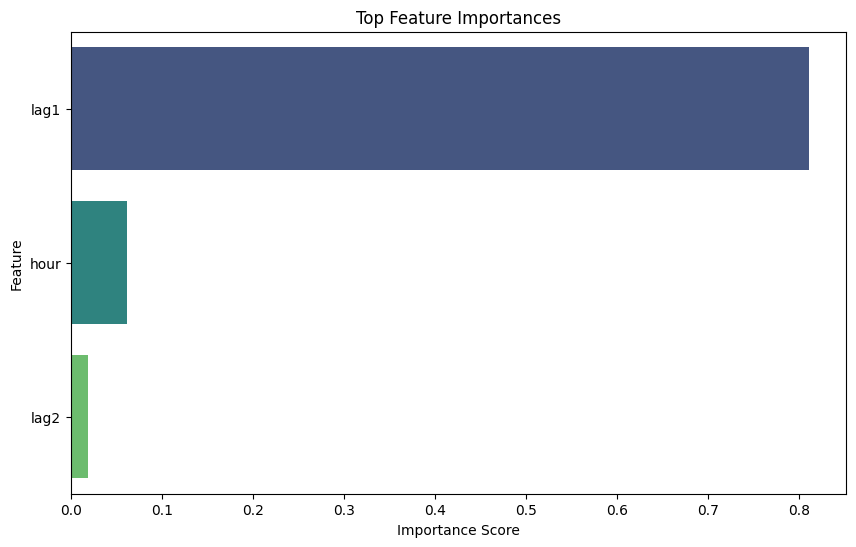

Random Forest - Validation MSE for dataset 498: 0.0301, RMSE: 0.1736
XGBoost - Validation MSE for dataset 498: 0.0327, RMSE: 0.1809
Models saved for dataset 498 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 498: 0.0306, RMSE: 0.1749
Top 3 features importance:
  Feature  Importance
0    lag1    0.950973
1    hour    0.018680
2    lag3    0.010093


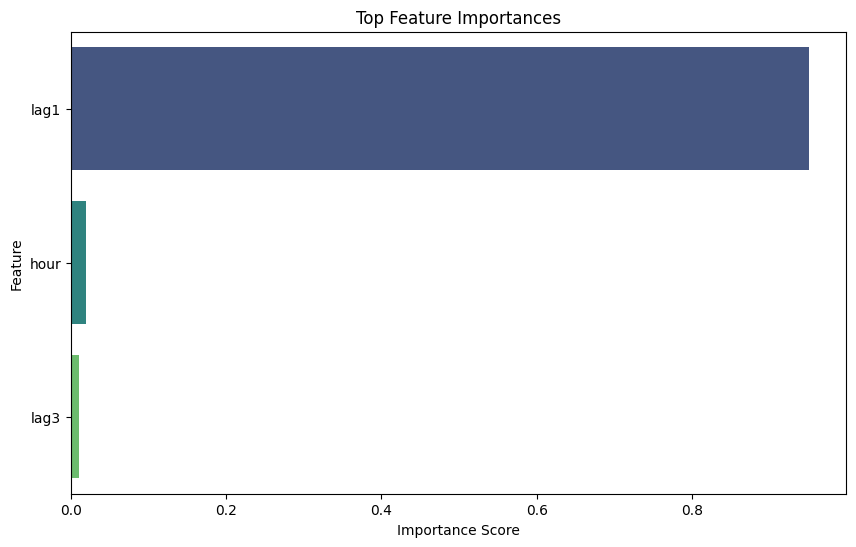

Random Forest - Validation MSE for dataset 499: 0.0019, RMSE: 0.0434
XGBoost - Validation MSE for dataset 499: 0.0009, RMSE: 0.0293
Models saved for dataset 499 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 499: 0.0012, RMSE: 0.0340
Top 3 features importance:
         Feature  Importance
0           lag1    0.909943
1           hour    0.047187
2  rolling_max_7    0.011223


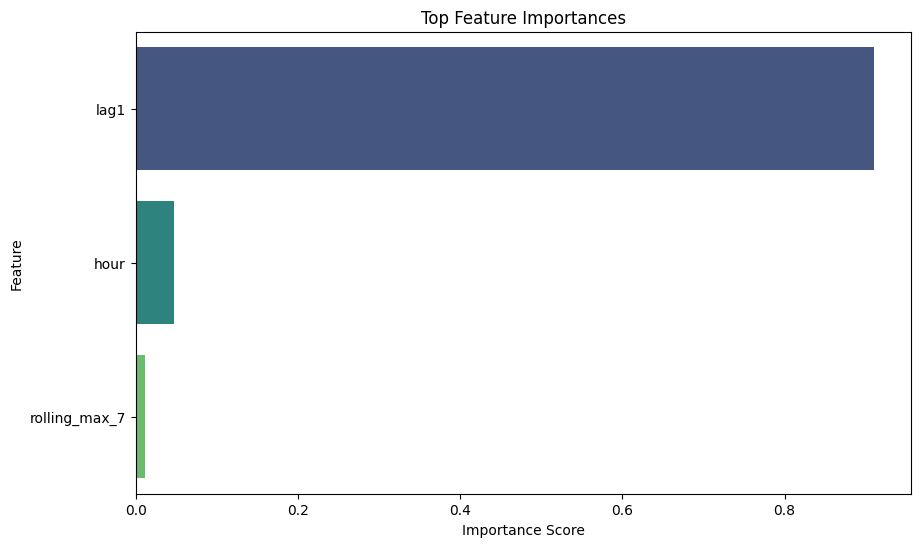

Random Forest - Validation MSE for dataset 505: 0.0016, RMSE: 0.0403
XGBoost - Validation MSE for dataset 505: 0.0011, RMSE: 0.0337
Models saved for dataset 505 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 505: 0.0011, RMSE: 0.0338
Top 3 features importance:
  Feature  Importance
0    lag1    0.911376
1    hour    0.038778
2    lag5    0.019181


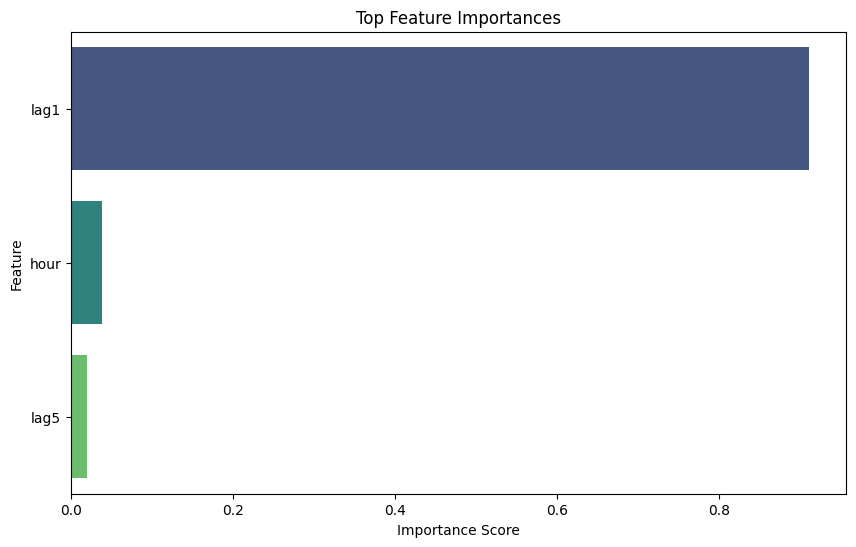

Random Forest - Validation MSE for dataset 506: 0.0054, RMSE: 0.0735
XGBoost - Validation MSE for dataset 506: 0.0012, RMSE: 0.0344
Models saved for dataset 506 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 506: 0.0024, RMSE: 0.0487
Top 3 features importance:
          Feature  Importance
0            hour    0.849039
1            lag1    0.111292
2  rolling_mean_3    0.010244


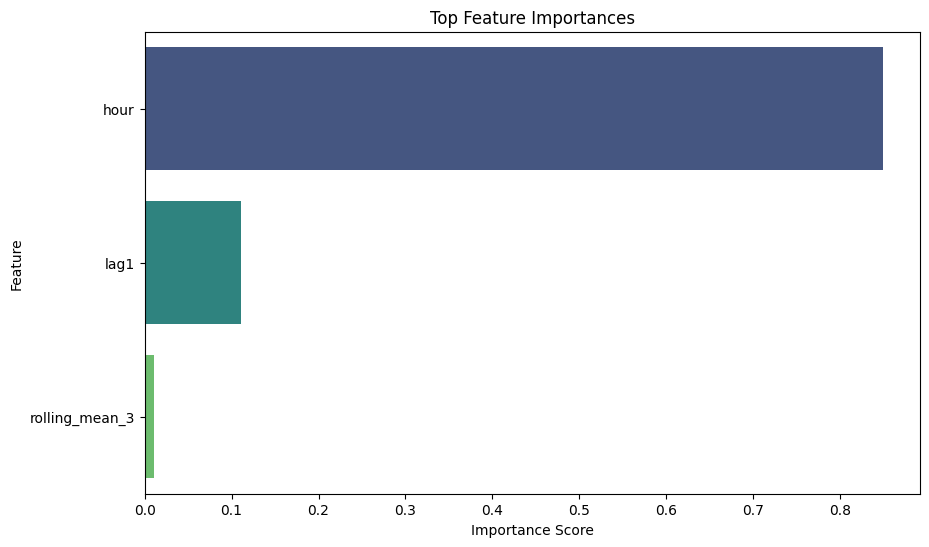

Random Forest - Validation MSE for dataset 507: 0.0094, RMSE: 0.0970
XGBoost - Validation MSE for dataset 507: 0.0108, RMSE: 0.1039
Models saved for dataset 507 in directory E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4
Ensemble - Validation MSE for dataset 507: 0.0097, RMSE: 0.0987


In [13]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Function to calculate importance
def get_feature_importance(X, y, model=None, top_n=6, plot=False):
    if model is None:
        model = RandomForestRegressor(n_estimators=50, random_state=42)
    
    model.fit(X, y)
    
    feature_importances = model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    
    importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    top_features = importance_df.head(top_n)
    
    print(f"Top {top_n} features importance:")
    print(top_features)
    
    if plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
        plt.title("Top Feature Importances")
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.show()
    
    return top_features['Feature'].tolist()

# Main training function with model saving
def train_and_save_model(dataset_id, train_dir="path/to/file", test_dir="path/to/file", model_dir="models"):
    os.makedirs(model_dir, exist_ok=True)

    def load_dataset(dataset_id, train_dir, test_dir):
        train_file = os.path.join(train_dir, f'train_{dataset_id}.csv')
        test_file = os.path.join(test_dir, f'test_{dataset_id}.csv')
        
        train_df = pd.read_csv(train_file, usecols=['timestamp', 'value'], parse_dates=['timestamp'])
        test_df = pd.read_csv(test_file, usecols=['timestamp', 'value'], parse_dates=['timestamp'])
        
        return train_df, test_df

    train_df, test_df = load_dataset(dataset_id, train_dir, test_dir)
    
    train_df['dataset_id'] = dataset_id

    training_data = train_df.rename(columns={'timestamp': 'time'}).copy()

    training_data['time'] = pd.to_datetime(training_data['time'])

    training_data = training_data.sort_values('time').reset_index(drop=True)

    def create_features(df):
        # Time-based features
        df['hour'] = df['time'].dt.hour
        df['minute'] = df['time'].dt.minute
        df['dayofweek'] = df['time'].dt.dayofweek
        df['month'] = df['time'].dt.month
        df['quarter'] = df['time'].dt.quarter
        df['trend'] = np.arange(len(df))
        
        # Lag features
        for lag in range(1, 6):
            df[f'lag{lag}'] = df['value'].shift(lag)
        
        # Rolling statistics
        df['rolling_mean_3'] = df['value'].shift(1).rolling(window=3).mean()
        df['rolling_std_3'] = df['value'].shift(1).rolling(window=3).std()
        df['rolling_max_7'] = df['value'].shift(1).rolling(window=7).max()
        df['rolling_min_7'] = df['value'].shift(1).rolling(window=7).min()
        df['rolling_median_7'] = df['value'].shift(1).rolling(window=7).median()

        df['S_day'] = np.sqrt(
            np.sin(2 * np.pi * df['hour'] / 24) ** 2 +
            np.cos(2 * np.pi * df['hour'] / 24) ** 2
        )
        df['S_week'] = np.sqrt(
            np.sin(2 * np.pi * df['dayofweek'] / 7) ** 2 +
            np.cos(2 * np.pi * df['dayofweek'] / 7) ** 2
        )
        
        return df.drop(columns=['time'])

    def hour_sampling(df):
        # Resample to hourly frequency
        df = df.set_index('time').resample('H').mean().reset_index()
        return df
    
    # Apply hourly sampling
    training_data = hour_sampling(training_data)

    # Create features and interpolate
    training_data = training_data.interpolate(method='linear').dropna()
    
    # Create features and interpolate
    training_data = create_features(training_data).interpolate(method='linear').dropna()
    
    feature_cols = [
        'hour', 'minute', 'dayofweek', 'month', 'quarter', 'trend',
        'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
        'rolling_mean_3', 'rolling_std_3', 'rolling_max_7', 'rolling_min_7', 'rolling_median_7'
        , 'S_day', 'S_week'
    ]
    
    X = training_data[feature_cols]
    y = training_data['value']

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Feature importance
    top_features = get_feature_importance(X, y, top_n=3, plot=True)
    X_top = X_train[top_features]
    X_test_top = X_val[top_features]

    # Train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth= 11,
        max_features='sqrt', 
        random_state=42)
    rf_model.fit(X_top, y_train)
    
    rf_pred = rf_model.predict(X_test_top)
    rf_mse = mean_squared_error(y_val, rf_pred)
    rf_rmse = np.sqrt(rf_mse)
    print(f"Random Forest - Validation MSE for dataset {dataset_id}: {rf_mse:.4f}, RMSE: {rf_rmse:.4f}")

    rf_filename = os.path.join(model_dir, f"rf_model_{dataset_id}.joblib")
    joblib.dump(rf_model, rf_filename)

    # Train XGBoost model
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.12, random_state=42, eval_metric='rmse')
    xgb_model.fit(X_top, y_train, eval_set=[(X_test_top, y_val)], verbose=False)
    
    xgb_pred = xgb_model.predict(X_test_top)
    xgb_mse = mean_squared_error(y_val, xgb_pred)
    xgb_rmse = np.sqrt(xgb_mse)
    print(f"XGBoost - Validation MSE for dataset {dataset_id}: {xgb_mse:.4f}, RMSE: {xgb_rmse:.4f}")

    xgb_filename = os.path.join(model_dir, f"xgb_model_{dataset_id}.joblib")
    joblib.dump(xgb_model, xgb_filename)

    print(f"Models saved for dataset {dataset_id} in directory {model_dir}")

    # Ensemble Prediction
    ensemble_pred = (rf_pred + xgb_pred) / 2
    ensemble_mse = mean_squared_error(y_val, ensemble_pred)
    ensemble_rmse = np.sqrt(ensemble_mse)
    print(f"Ensemble - Validation MSE for dataset {dataset_id}: {ensemble_mse:.4f}, RMSE: {ensemble_rmse:.4f}")




train_path= r'E:/Assignments/Time Series/Data_splits/train_splits/'
test_path= r'E:/Assignments/Time Series/Data_splits/test_splits/'
model_path = r'E:/Assignments/Time Series/Time_Series_Project/data/New_Model_4'


# dataset_ids = 9
# train_and_save_model(dataset_ids, train_path, test_path, model_path)
for num in sorted_nums:
    dataset_ids = num
    train_and_save_model(dataset_ids, train_path, test_path, model_path)